In [114]:
import numpy as np
import matplotlib.pyplot as plt

In [115]:
import os
import json
import pandas as pd
from sqlalchemy import text
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import gensim

In [116]:
normalized_dir = "./polarities/normalized"

In [117]:
subreddits = list()

In [118]:
subreddit_polarities = dict()
for subreddit in os.listdir(normalized_dir):
    if subreddit.split('.')[-1] == 'json':
        if subreddit.split('_standardized')[0] != 'BingeEatingRecovery':
            with open(os.path.join(normalized_dir,subreddit)) as f:
                subreddit_polarities[subreddit.split('_standardized')[0]] = json.load(f)
                subreddits.append(subreddit.split('_standardized')[0])

In [119]:
subreddits

['AnorexiaRecovery',
 'bingeeating',
 'eating_disorders',
 'EdAnonymousAdults',
 'EatingDisorderHope',
 'selftext',
 'bulimia',
 'BulimiaRecovery',
 'EDRecovery_public',
 'BingeEatingDisorder',
 'EatingDisorders',
 'anorexiaflareuphelp',
 'edsupport',
 'PurgingDisorder',
 'AnorexiaNervosa',
 'BulimiaAndAnaSupport',
 'EDAnonymous',
 'NotOtherwiseSpecified']

In [90]:
common = list(subreddit_polarities[subreddits[0]].keys())
for subreddit in subreddits:
#     print(subreddit)
    common = [value for value in common if value in subreddit_polarities[subreddit].keys()]

In [92]:
df_list = list()
for word in common:
    for subreddit in subreddits:
        df_list.append({'subreddit': subreddit, 'word': word, 'polarity': subreddit_polarities[subreddit][word]})

In [93]:
shared_words = pd.DataFrame.from_dict(df_list)

In [94]:
shared_words

,subreddit,word,polarity
0,AnorexiaRecovery,want,-0.319114
1,bingeeating,want,0.147042
2,eating_disorders,want,-2.114622
3,EdAnonymousAdults,want,-7.227650
4,EatingDisorderHope,want,-1.934358
...,...,...,...
769,PurgingDisorder,know,-0.042790
770,AnorexiaNervosa,know,-1.111143
771,BulimiaAndAnaSupport,know,4.377576
772,EDAnonymous,know,-4.385993


In [15]:
sqlite_path = "./reddit_ed_0.6.0.sqlite3"
engine = create_engine(
    f"sqlite:///{sqlite_path}",
    connect_args={"check_same_thread":False},
)

In [16]:
query = f"select subreddit, count(*) as count from subreddit_submission_metadata group by subreddit;"
subreddits = pd.read_sql_query(text(query),con=engine.connect())

In [97]:
merged_df = shared_words.merge(subreddits,how='inner',on='subreddit')

In [99]:
merged_df[merged_df['word']=="food"].sort_values(by='polarity')

,subreddit,word,polarity,count
165,EdAnonymousAdults,food,-5.284351,4954
681,EDAnonymous,food,-3.306161,3910
251,bulimia,food,-1.825423,2326
122,eating_disorders,food,-0.839858,3663
208,EatingDisorderHope,food,-0.815537,99
638,BulimiaAndAnaSupport,food,-0.680637,117
380,BingeEatingDisorder,food,-0.259065,393
423,EatingDisorders,food,-0.226930,904
509,edsupport,food,-0.205861,83
79,bingeeating,food,-0.181133,421


# Keyword Comparison

In [111]:
keywords = [
    "eat",
    "eating",
    "drink",
    "food",
    "gain", 
    "gained",
    "gaining",
    "lose",
    "lost",
    "losing",
    "weight", 
    "exercise", 
    "exercising",
    "exercised",
    "recovery",
    "relapse",
    "relapsed",
    "therapy",
    "hospital",
    "doctor",
    "nurse",
    "body",
    "family"
]

In [24]:
sorted_edanonymous_polarities = dict(sorted(subreddit_polarities["EDAnonymous"].items(), key=lambda item: item[1]))

In [29]:
print(f"EDAnonymous most negative word: {list(sorted_edanonymous_polarities.items())[0]} \nEDAnonymous most positive word: {list(sorted_edanonymous_polarities.items())[-1]}")


EDAnonymous most negative word: ('disappointed', -14.26873112516215) 
EDAnonymous most positive word: ('loving', 14.53987153536562)


In [120]:
keyword_scores = dict()

In [121]:
for keyword in keywords:
    keyword_scores[keyword] = dict()
    for subreddit in subreddits:
        if keyword in subreddit_polarities[subreddit].keys():
            keyword_scores[keyword][subreddit] = subreddit_polarities[subreddit][keyword]
        else:
            keyword_scores[keyword][subreddit] = 0

In [63]:
dict(sorted(keyword_scores["eat"].items(), key=lambda item: item[1]))

{'EdAnonymousAdults': -6.684741530465614,
 'selftext': -3.9911441469958167,
 'EDAnonymous': -3.828017185259774,
 'EatingDisorderHope': -2.1337942719970964,
 'eating_disorders': -1.6561770702431415,
 'bulimia': -0.3565905111456042,
 'EatingDisorders': -0.22855594062950688,
 'BulimiaRecovery': -0.1546821483718844,
 'NotOtherwiseSpecified': -0.10015545083120789,
 'EDRecovery_public': -0.08960636086795665,
 'PurgingDisorder': -0.04278997999343847,
 'BulimiaAndAnaSupport': -0.011899276926267683,
 'bingeeating': 0.005148540369127633,
 'AnorexiaNervosa': 0.03825491089186577,
 'BingeEatingDisorder': 0.08397916088341413,
 'edsupport': 0.29454764142009593,
 'anorexiaflareuphelp': 0.4221634005634859,
 'AnorexiaRecovery': 1.8778797585188083}

In [64]:
dict(sorted(keyword_scores["eating"].items(), key=lambda item: item[1]))

{'EdAnonymousAdults': -6.575621612342669,
 'EDAnonymous': -3.7448463662834977,
 'selftext': -3.4429998916097535,
 'BulimiaAndAnaSupport': -1.8393968654732524,
 'eating_disorders': -0.8759853544192222,
 'anorexiaflareuphelp': -0.600279007185873,
 'EatingDisorders': -0.3368377951932086,
 'bulimia': -0.32364617193240625,
 'bingeeating': -0.1437711270151641,
 'BulimiaRecovery': -0.12612519391390947,
 'BingeEatingDisorder': -0.09128772891348642,
 'PurgingDisorder': -0.04278997999343847,
 'AnorexiaNervosa': -0.02043865027033414,
 'EDRecovery_public': 0.05588180309738335,
 'NotOtherwiseSpecified': 0.13062686334678464,
 'edsupport': 0.7617676610024667,
 'EatingDisorderHope': 0.7661338553240781,
 'AnorexiaRecovery': 1.7465208022504286}

In [65]:
dict(sorted(keyword_scores["food"].items(), key=lambda item: item[1]))

{'EdAnonymousAdults': -5.2843509633191434,
 'EDAnonymous': -3.3061606990049373,
 'selftext': -3.282968599347329,
 'bulimia': -1.825422691661064,
 'eating_disorders': -0.8398582080984942,
 'EatingDisorderHope': -0.815536941113765,
 'BulimiaAndAnaSupport': -0.6806367940321293,
 'BingeEatingDisorder': -0.25906547568088883,
 'EatingDisorders': -0.22693036766897506,
 'edsupport': -0.20586110530840093,
 'bingeeating': -0.18113333243968407,
 'AnorexiaNervosa': -0.08014478498851244,
 'NotOtherwiseSpecified': -0.07673189017956288,
 'PurgingDisorder': -0.04278997999343847,
 'EDRecovery_public': -0.032251901649976024,
 'anorexiaflareuphelp': 0.3243461016874401,
 'BulimiaRecovery': 0.41788986214965823,
 'AnorexiaRecovery': 0.7453365163386063}

In [66]:
dict(sorted(keyword_scores["weight"].items(), key=lambda item: item[1]))

{'EdAnonymousAdults': -4.940309789483588,
 'EDAnonymous': -2.9763551599416123,
 'EatingDisorderHope': -2.119210409551989,
 'selftext': -1.4868987488969354,
 'BulimiaAndAnaSupport': -0.9450632333823498,
 'edsupport': -0.6352506333967762,
 'eating_disorders': -0.39728491413402883,
 'BulimiaRecovery': -0.275714991119904,
 'AnorexiaNervosa': -0.1454845868511857,
 'anorexiaflareuphelp': -0.12578375691807067,
 'AnorexiaRecovery': -0.05653185365288687,
 'PurgingDisorder': -0.04278997999343847,
 'NotOtherwiseSpecified': 0,
 'BingeEatingDisorder': 0.048310973363290294,
 'EDRecovery_public': 0.05506844237661227,
 'bingeeating': 0.10158729751898096,
 'bulimia': 0.2742639295462902,
 'EatingDisorders': 0.7077632818416318}

In [67]:
dict(sorted(keyword_scores["gain"].items(), key=lambda item: item[1]))

{'EatingDisorderHope': -1.4337188012167057,
 'EdAnonymousAdults': -1.3864307403102685,
 'selftext': -0.836943186257188,
 'edsupport': -0.5864366407412065,
 'EDAnonymous': -0.48032279815442075,
 'bingeeating': -0.38061788989454004,
 'BulimiaRecovery': -0.2964951684430267,
 'EDRecovery_public': -0.16544290862700722,
 'AnorexiaNervosa': -0.03777070065972426,
 'anorexiaflareuphelp': 0,
 'PurgingDisorder': 0,
 'NotOtherwiseSpecified': 0,
 'bulimia': 0.032393612162226366,
 'BingeEatingDisorder': 0.04848200542766314,
 'AnorexiaRecovery': 0.45427812236015425,
 'BulimiaAndAnaSupport': 0.8004376598343864,
 'eating_disorders': 2.235439347060017,
 'EatingDisorders': 2.3121848092956223}

In [68]:
dict(sorted(keyword_scores["gained"].items(), key=lambda item: item[1]))

{'BingeEatingDisorder': -1.0935646976788678,
 'selftext': -1.0496758157674233,
 'EdAnonymousAdults': -0.9888025737342806,
 'edsupport': -0.8441085304878367,
 'EatingDisorderHope': -0.36070374536429967,
 'bingeeating': -0.0659463691130857,
 'AnorexiaNervosa': -0.027870266344228553,
 'BulimiaAndAnaSupport': -0.009836302057883325,
 'PurgingDisorder': 0,
 'NotOtherwiseSpecified': 0,
 'EDAnonymous': 0.0014265317415762344,
 'bulimia': 0.0064132729809364755,
 'EDRecovery_public': 0.05337977521920983,
 'BulimiaRecovery': 0.35244102855130394,
 'anorexiaflareuphelp': 0.46308388179297255,
 'AnorexiaRecovery': 0.5014775548845303,
 'eating_disorders': 0.6922281743980739,
 'EatingDisorders': 7.521089309585316}

In [69]:
dict(sorted(keyword_scores["gaining"].items(), key=lambda item: item[1]))

{'EatingDisorderHope': -1.9729474844820971,
 'EdAnonymousAdults': -1.888242687494107,
 'selftext': -0.8279712170787533,
 'edsupport': -0.41365124555005545,
 'BulimiaAndAnaSupport': -0.27753077288346506,
 'AnorexiaNervosa': -0.1273711934586739,
 'bingeeating': -0.07376943718993362,
 'EDRecovery_public': -0.016489538133945693,
 'BulimiaRecovery': 0,
 'anorexiaflareuphelp': 0,
 'PurgingDisorder': 0,
 'NotOtherwiseSpecified': 0,
 'bulimia': 0.009474540877069362,
 'BingeEatingDisorder': 0.029328170874413848,
 'EDAnonymous': 0.14729424636105262,
 'AnorexiaRecovery': 0.5565559135467548,
 'eating_disorders': 0.7703885714098542,
 'EatingDisorders': 2.303362034608182}

In [70]:
dict(sorted(keyword_scores["losing"].items(), key=lambda item: item[1]))

{'EdAnonymousAdults': -2.056018484889376,
 'edsupport': -1.1234928796442325,
 'selftext': -0.8375408982013914,
 'bingeeating': -0.6017019223943806,
 'BulimiaRecovery': -0.18603237978249074,
 'AnorexiaNervosa': -0.020595383036596183,
 'EatingDisorderHope': -0.01411279959560823,
 'PurgingDisorder': 0,
 'NotOtherwiseSpecified': 0,
 'bulimia': 0.006988107692788223,
 'BingeEatingDisorder': 0.01534996879262142,
 'EDAnonymous': 0.02977406101407341,
 'EDRecovery_public': 0.06553440647189217,
 'anorexiaflareuphelp': 0.47413030760132885,
 'eating_disorders': 0.6495440944455457,
 'BulimiaAndAnaSupport': 1.3575632297888394,
 'AnorexiaRecovery': 1.7131063848095536,
 'EatingDisorders': 2.287611853406844}

In [73]:
dict(sorted(keyword_scores["exercise"].items(), key=lambda item: item[1]))

{'EdAnonymousAdults': -3.607664360755767,
 'selftext': -3.0719139979567816,
 'EDAnonymous': -1.8086482768991015,
 'EatingDisorderHope': -1.34721203461359,
 'eating_disorders': -1.3140076440951884,
 'AnorexiaRecovery': -0.07821339759195142,
 'bingeeating': -0.040472808700351255,
 'BulimiaAndAnaSupport': -0.02757993042321606,
 'bulimia': -0.0013896081075617903,
 'BulimiaRecovery': 0,
 'anorexiaflareuphelp': 0,
 'PurgingDisorder': 0,
 'NotOtherwiseSpecified': 0,
 'EDRecovery_public': 0.0428577280280738,
 'EatingDisorders': 0.05525124691801582,
 'BingeEatingDisorder': 0.07769719221441866,
 'AnorexiaNervosa': 0.33182472888204034,
 'edsupport': 0.8663063439023286}

In [74]:
dict(sorted(keyword_scores["recovery"].items(), key=lambda item: item[1]))

{'anorexiaflareuphelp': 2.538787540959024,
 'BulimiaRecovery': 3.117476436678474,
 'EatingDisorderHope': 5.1583710178059015,
 'edsupport': 7.0078847691747015,
 'NotOtherwiseSpecified': 7.242150207208292,
 'BulimiaAndAnaSupport': 7.965300257182804,
 'bingeeating': 8.099254461566748,
 'PurgingDisorder': 8.160076172694088,
 'selftext': 8.329629146817725,
 'EdAnonymousAdults': 8.934841106137359,
 'BingeEatingDisorder': 10.469805832626061,
 'EDRecovery_public': 11.507604041673838,
 'eating_disorders': 11.836421556942645,
 'AnorexiaRecovery': 12.84269398173431,
 'AnorexiaNervosa': 14.049697402820176,
 'EDAnonymous': 14.26648912433481,
 'EatingDisorders': 14.439920320410408,
 'bulimia': 15.199595057531221}

In [75]:
dict(sorted(keyword_scores["relapse"].items(), key=lambda item: item[1]))

{'EatingDisorders': -14.080954729893818,
 'AnorexiaNervosa': -13.841505000650649,
 'EDAnonymous': -13.625026501799649,
 'bulimia': -12.123718699712354,
 'eating_disorders': -11.217226327363868,
 'BulimiaRecovery': -11.186099053333548,
 'EDRecovery_public': -11.06121464194216,
 'BingeEatingDisorder': -10.072461564191972,
 'AnorexiaRecovery': -10.006249008292802,
 'EdAnonymousAdults': -8.403854203936485,
 'bingeeating': -7.910072835364409,
 'BulimiaAndAnaSupport': -7.619198220150584,
 'selftext': -6.813388733731937,
 'edsupport': -6.51394988335956,
 'anorexiaflareuphelp': -3.659905734822165,
 'EatingDisorderHope': -3.4157189323507295,
 'PurgingDisorder': 0,
 'NotOtherwiseSpecified': 0}

In [76]:
dict(sorted(keyword_scores["relapsed"].items(), key=lambda item: item[1]))

{'eating_disorders': -7.097265739012118,
 'EDAnonymous': -6.8201752441550845,
 'selftext': -2.7643370457868532,
 'BulimiaAndAnaSupport': -0.25771077206783716,
 'EatingDisorderHope': -0.10282570549594233,
 'bulimia': -0.0812626404183583,
 'BulimiaRecovery': 0,
 'anorexiaflareuphelp': 0,
 'edsupport': 0,
 'PurgingDisorder': 0,
 'NotOtherwiseSpecified': 0,
 'bingeeating': 0.017336089499873496,
 'AnorexiaNervosa': 0.0188245910206493,
 'EatingDisorders': 0.026506465449043795,
 'EDRecovery_public': 0.06124315666583501,
 'BingeEatingDisorder': 0.11253440245188934,
 'EdAnonymousAdults': 0.5579395107112511,
 'AnorexiaRecovery': 7.816031789650467}

In [77]:
dict(sorted(keyword_scores["therapy"].items(), key=lambda item: item[1]))

{'bingeeating': -0.6079116975370529,
 'BulimiaAndAnaSupport': -0.09819107309489992,
 'bulimia': -0.05825123353802429,
 'AnorexiaRecovery': -0.044328035377662944,
 'PurgingDisorder': -0.04278997999343847,
 'BulimiaRecovery': 0,
 'anorexiaflareuphelp': 0,
 'AnorexiaNervosa': 0.04315949353652905,
 'eating_disorders': 0.0482870454311529,
 'EatingDisorders': 0.05173650434515339,
 'BingeEatingDisorder': 0.10871954758565379,
 'NotOtherwiseSpecified': 0.11440099095476411,
 'EDRecovery_public': 0.15421257529942323,
 'edsupport': 0.6243510887995762,
 'EatingDisorderHope': 0.8321873205850455,
 'EDAnonymous': 2.592546891147753,
 'EdAnonymousAdults': 3.340836331542262,
 'selftext': 4.6998834344463685}

In [78]:
dict(sorted(keyword_scores["hospital"].items(), key=lambda item: item[1]))

{'BulimiaAndAnaSupport': -0.03292509835481332,
 'AnorexiaNervosa': -0.00231167804432547,
 'EatingDisorderHope': 0,
 'BulimiaRecovery': 0,
 'BingeEatingDisorder': 0,
 'PurgingDisorder': 0,
 'NotOtherwiseSpecified': 0,
 'bulimia': 0.02783191041072061,
 'eating_disorders': 0.050277341130068265,
 'EatingDisorders': 0.05620243057366743,
 'EDRecovery_public': 0.058167364062570545,
 'bingeeating': 0.10760522814728486,
 'EDAnonymous': 0.11624708407415678,
 'anorexiaflareuphelp': 0.16260891343383083,
 'AnorexiaRecovery': 0.17398425573840784,
 'edsupport': 0.26173402088165143,
 'EdAnonymousAdults': 0.47116394354552127,
 'selftext': 3.4941410509919018}

In [79]:
dict(sorted(keyword_scores["doctor"].items(), key=lambda item: item[1]))

{'edsupport': -0.985617801682091,
 'BulimiaAndAnaSupport': -0.06200394650127218,
 'AnorexiaRecovery': -0.009565505287642249,
 'EatingDisorderHope': 0,
 'BulimiaRecovery': 0,
 'anorexiaflareuphelp': 0,
 'PurgingDisorder': 0,
 'NotOtherwiseSpecified': 0,
 'AnorexiaNervosa': 0.013730329955515208,
 'EDRecovery_public': 0.02662042553876239,
 'bingeeating': 0.041194518035743935,
 'EatingDisorders': 0.04225649029237842,
 'BingeEatingDisorder': 0.054188808927244536,
 'eating_disorders': 0.06688890803853152,
 'bulimia': 0.08951230037496095,
 'EDAnonymous': 0.2171080119570145,
 'selftext': 2.8597068409463975,
 'EdAnonymousAdults': 3.954498062565385}

In [80]:
dict(sorted(keyword_scores["nurse"].items(), key=lambda item: item[1]))

{'AnorexiaNervosa': -0.0030788725548076454,
 'bingeeating': 0,
 'EatingDisorderHope': 0,
 'BulimiaRecovery': 0,
 'anorexiaflareuphelp': 0,
 'PurgingDisorder': 0,
 'BulimiaAndAnaSupport': 0,
 'NotOtherwiseSpecified': 0,
 'bulimia': 0.008156743524694473,
 'EatingDisorders': 0.056528615175641554,
 'BingeEatingDisorder': 0.05686377600262203,
 'eating_disorders': 0.07622807867041141,
 'EDAnonymous': 0.08291330572634258,
 'AnorexiaRecovery': 0.08818669326217568,
 'EdAnonymousAdults': 0.16208103122371156,
 'edsupport': 0.16377735945650387,
 'EDRecovery_public': 0.23298357954228782,
 'selftext': 1.1000745388062645}

In [81]:
dict(sorted(keyword_scores["body"].items(), key=lambda item: item[1]))

{'EdAnonymousAdults': -5.4863696804638575,
 'BulimiaAndAnaSupport': -3.393858345305703,
 'selftext': -3.012033725827072,
 'EDAnonymous': -1.946793304405343,
 'eating_disorders': -1.5892705198450165,
 'edsupport': -0.763718883937251,
 'EatingDisorderHope': -0.763276378347939,
 'bingeeating': -0.6734114475905477,
 'AnorexiaNervosa': -0.21178677809625748,
 'bulimia': -0.20404553424422683,
 'BulimiaRecovery': -0.17333738875766722,
 'BingeEatingDisorder': -0.13229990005408496,
 'anorexiaflareuphelp': -0.08819511077856061,
 'PurgingDisorder': -0.04278997999343847,
 'NotOtherwiseSpecified': 0,
 'EatingDisorders': 0.03634185417063183,
 'AnorexiaRecovery': 0.4756739796691353,
 'EDRecovery_public': 4.335734881159487}

In [82]:
dict(sorted(keyword_scores["family"].items(), key=lambda item: item[1]))

{'EatingDisorderHope': -2.197244481362058,
 'EdAnonymousAdults': -1.026412390176563,
 'eating_disorders': -0.9295434098297286,
 'EDAnonymous': -0.9238768386733146,
 'BingeEatingDisorder': -0.3276624214138818,
 'PurgingDisorder': 0,
 'NotOtherwiseSpecified': 0,
 'bingeeating': 0.02124400485043036,
 'AnorexiaNervosa': 0.0360428828255183,
 'EDRecovery_public': 0.04876149286160614,
 'EatingDisorders': 0.05124293737602682,
 'bulimia': 0.051524709068131995,
 'selftext': 0.14114766539598508,
 'edsupport': 0.17861395679009381,
 'AnorexiaRecovery': 0.2759088826294038,
 'anorexiaflareuphelp': 0.50910041019699,
 'BulimiaRecovery': 0.5148705587413757,
 'BulimiaAndAnaSupport': 2.7029587811017315}

# Graphs

In [133]:
for keyword in keyword_scores:
    keyword_scores[keyword].pop('selftext')
    keyword_scores[keyword] = dict(sorted(keyword_scores[keyword].items(), key=lambda item: item[1]))

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


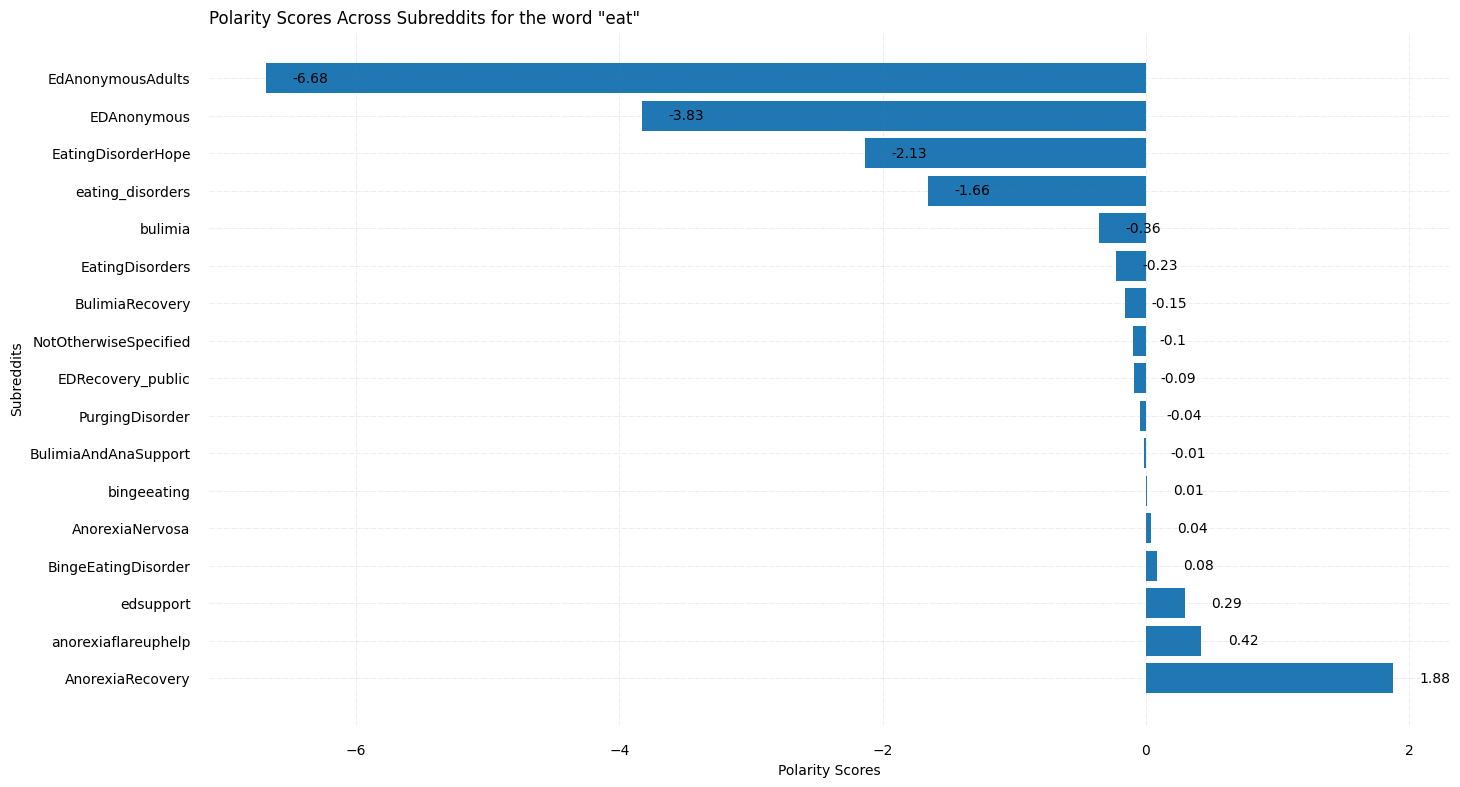

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


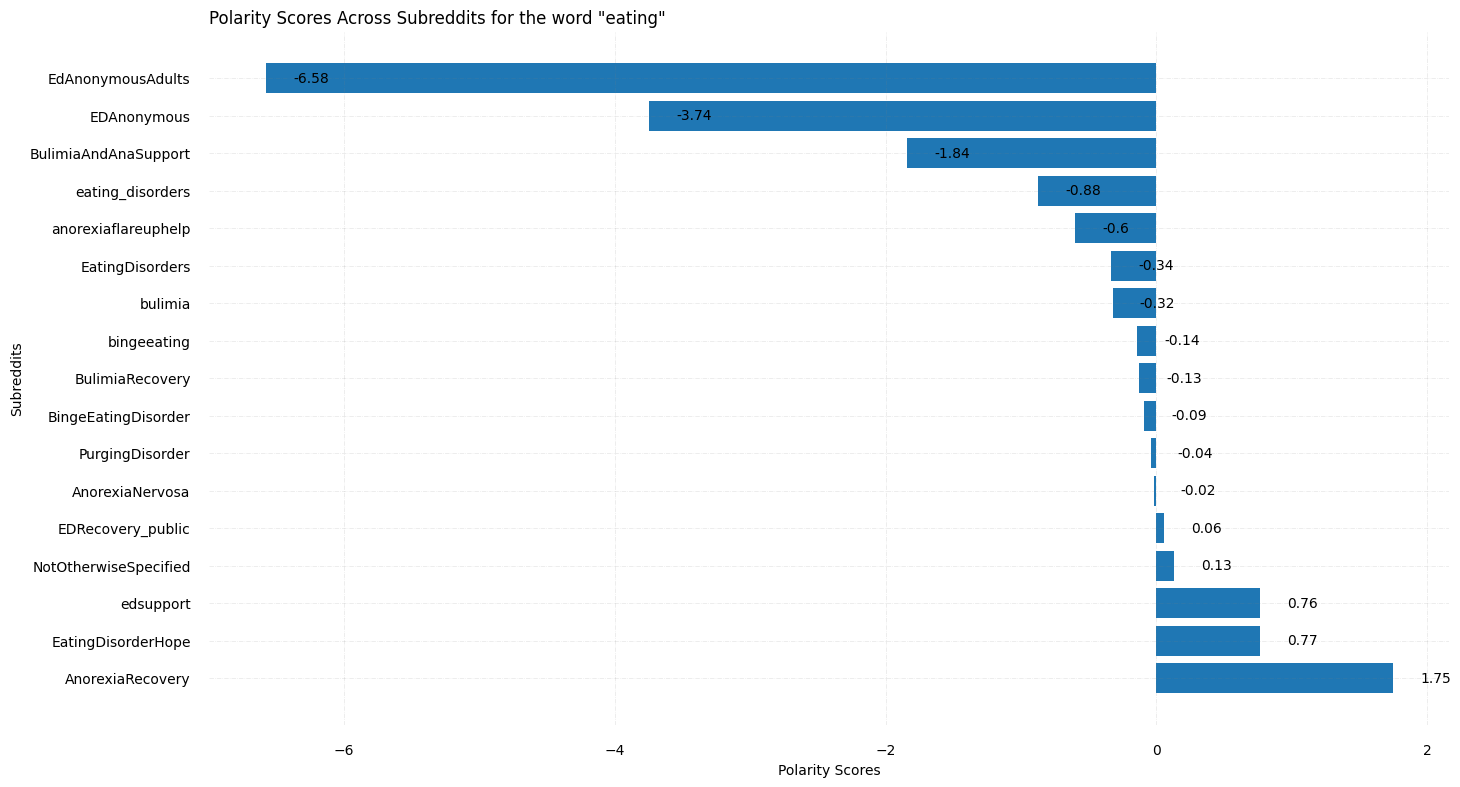

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


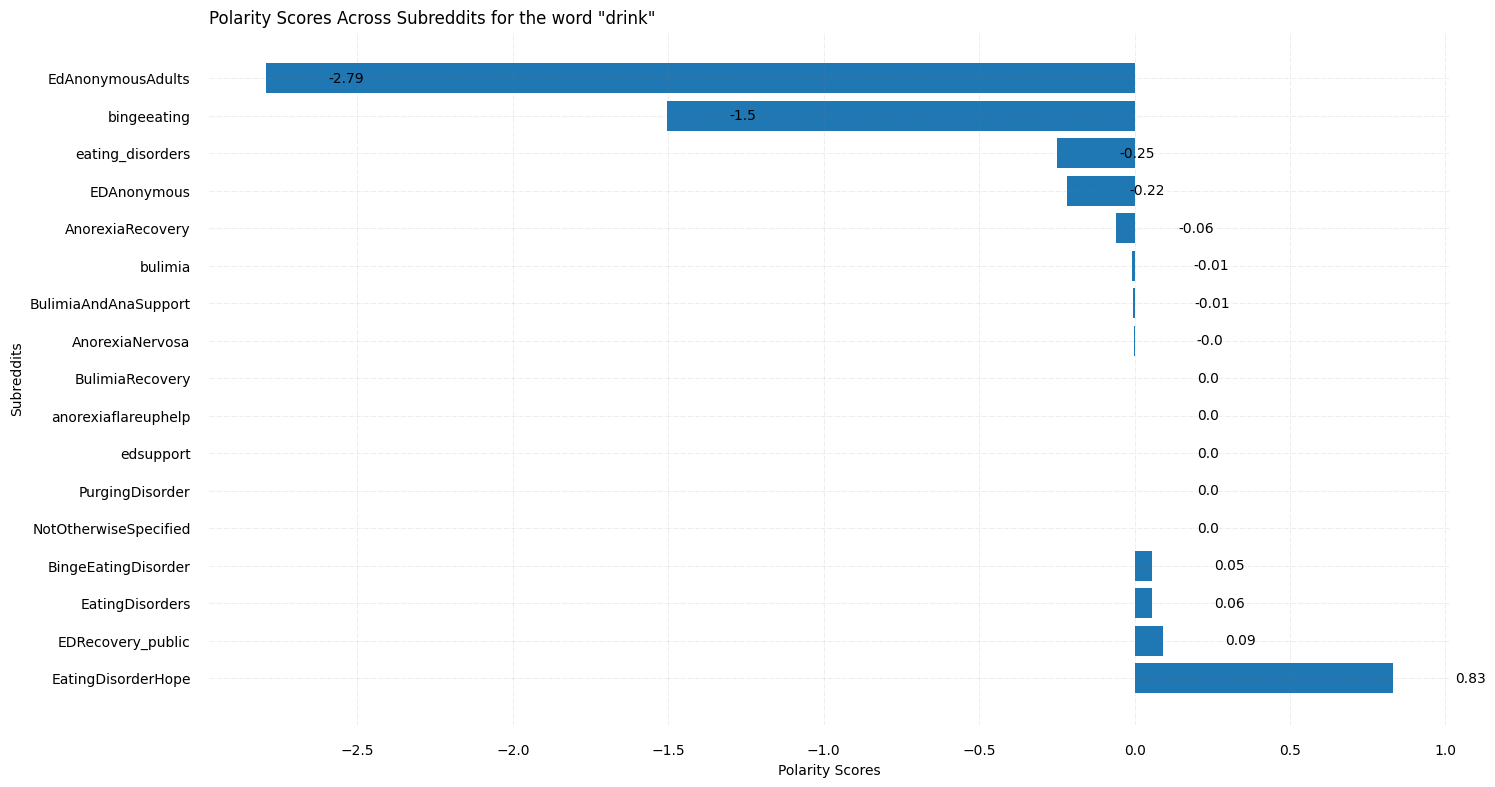

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


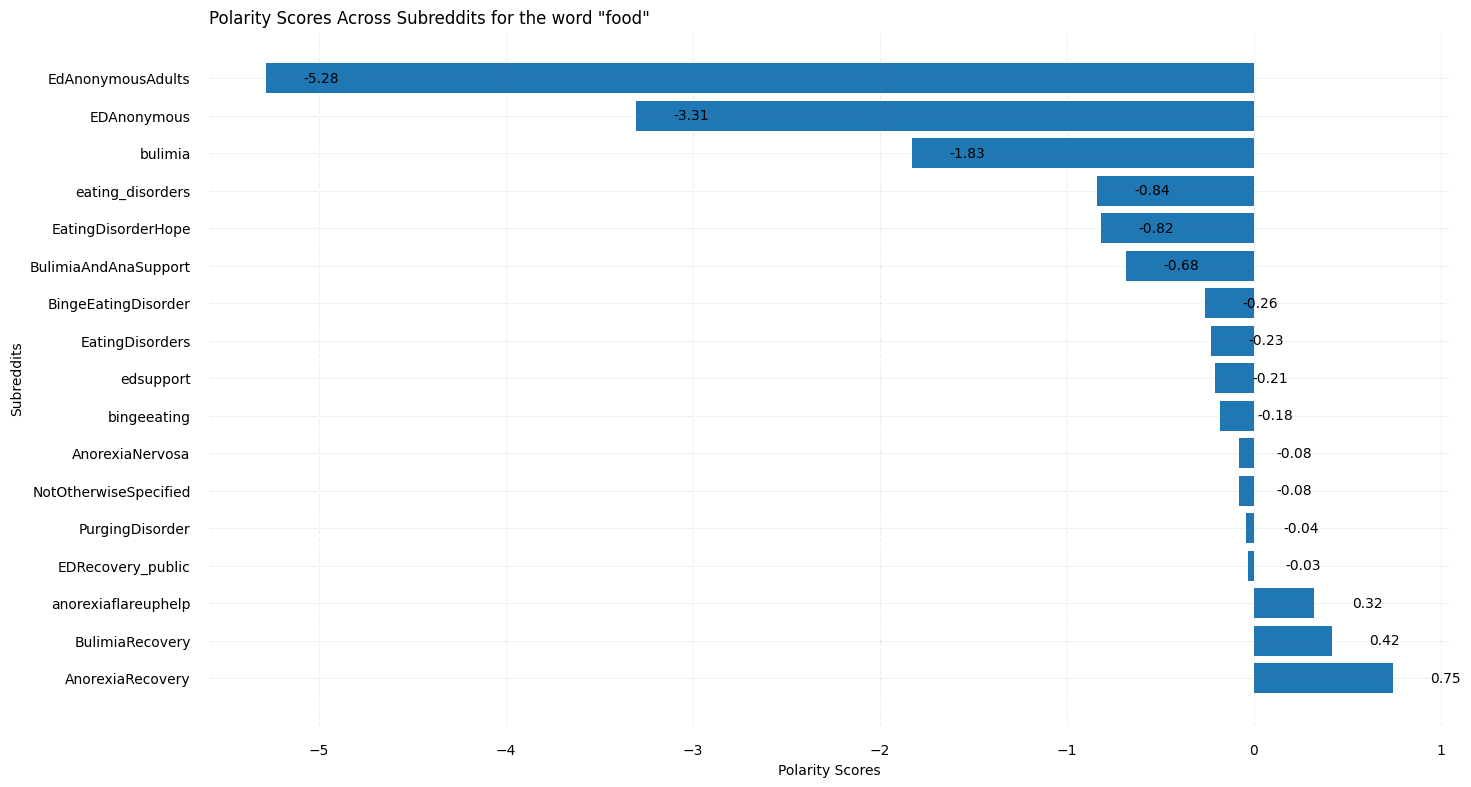

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


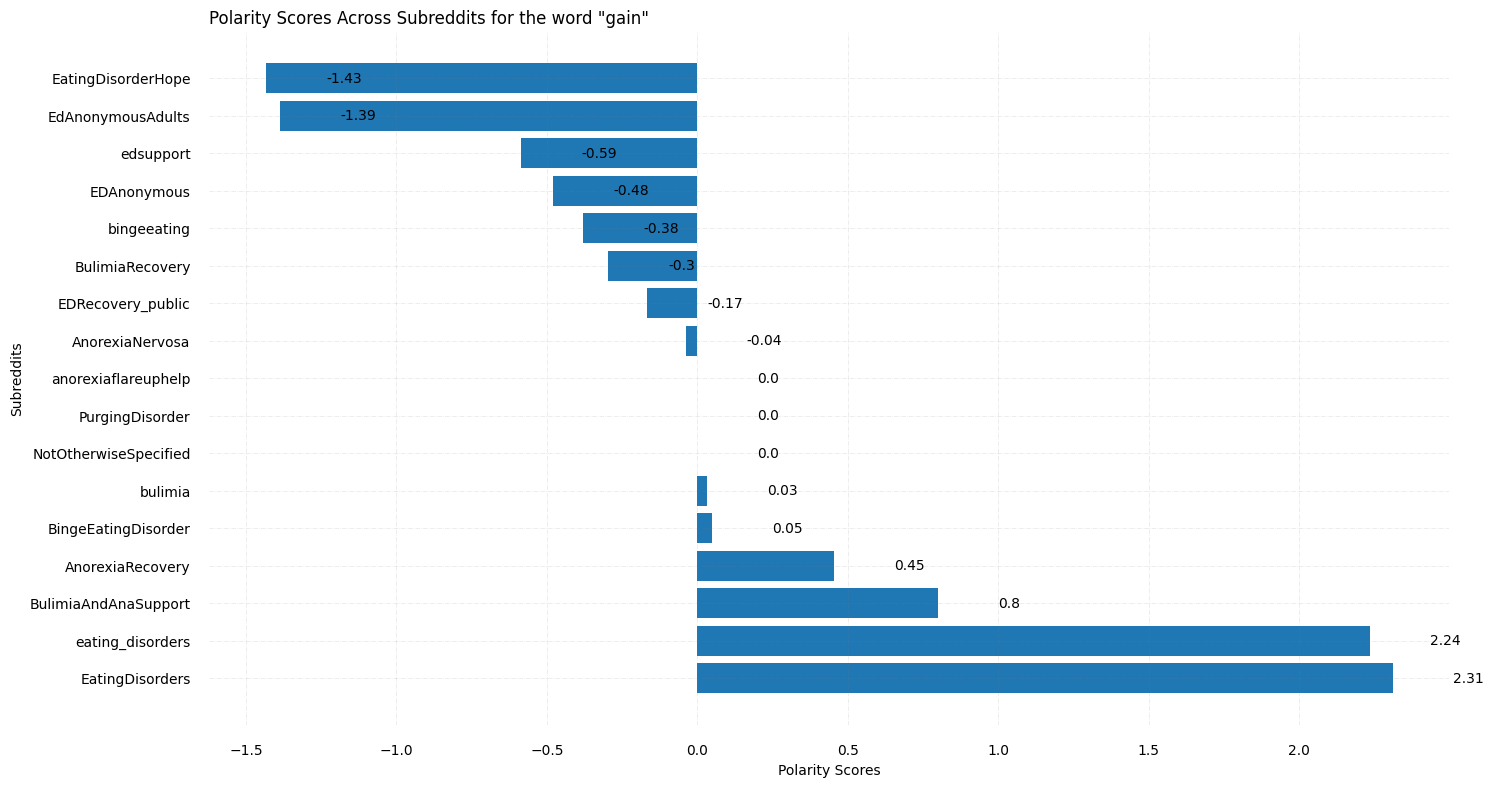

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


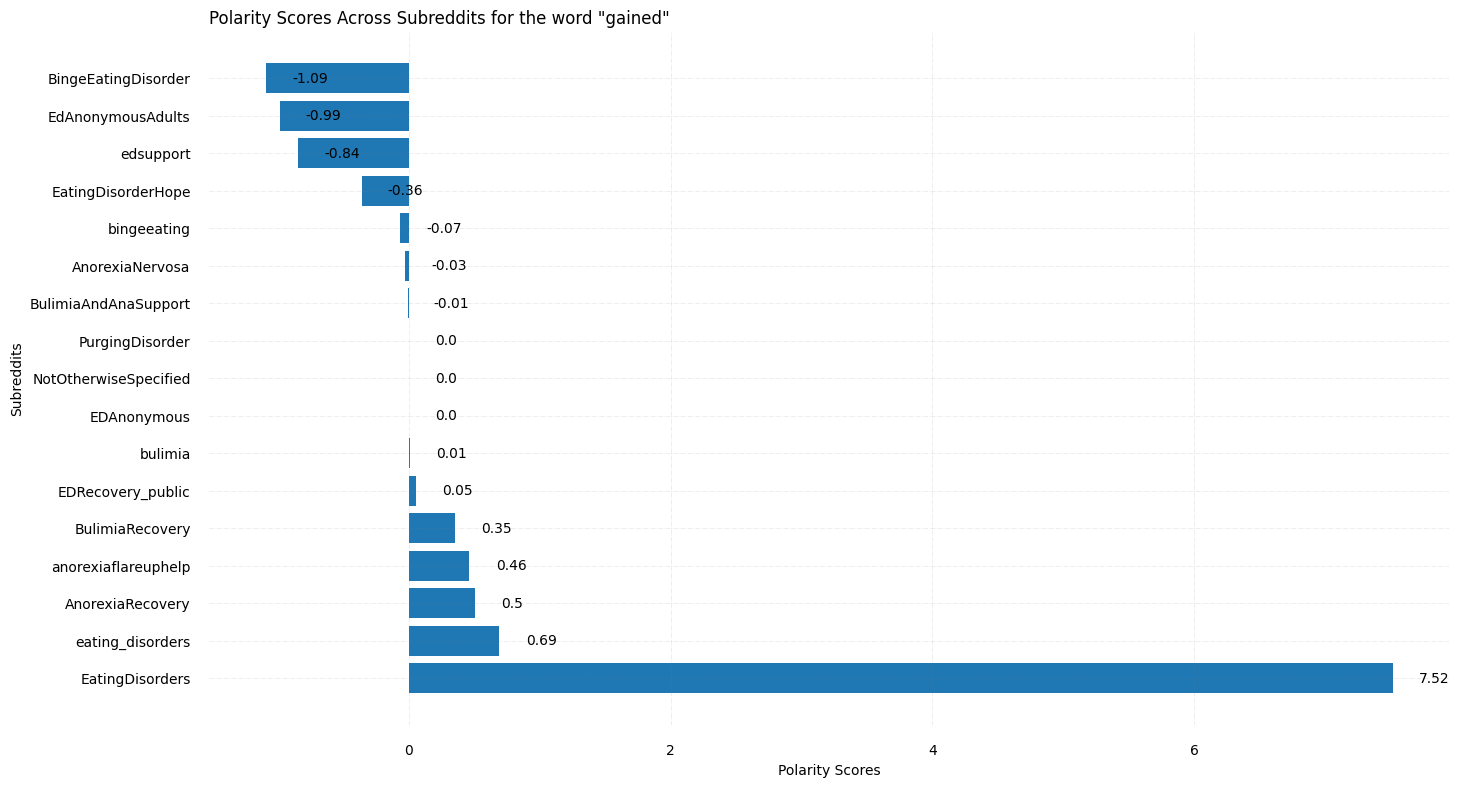

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


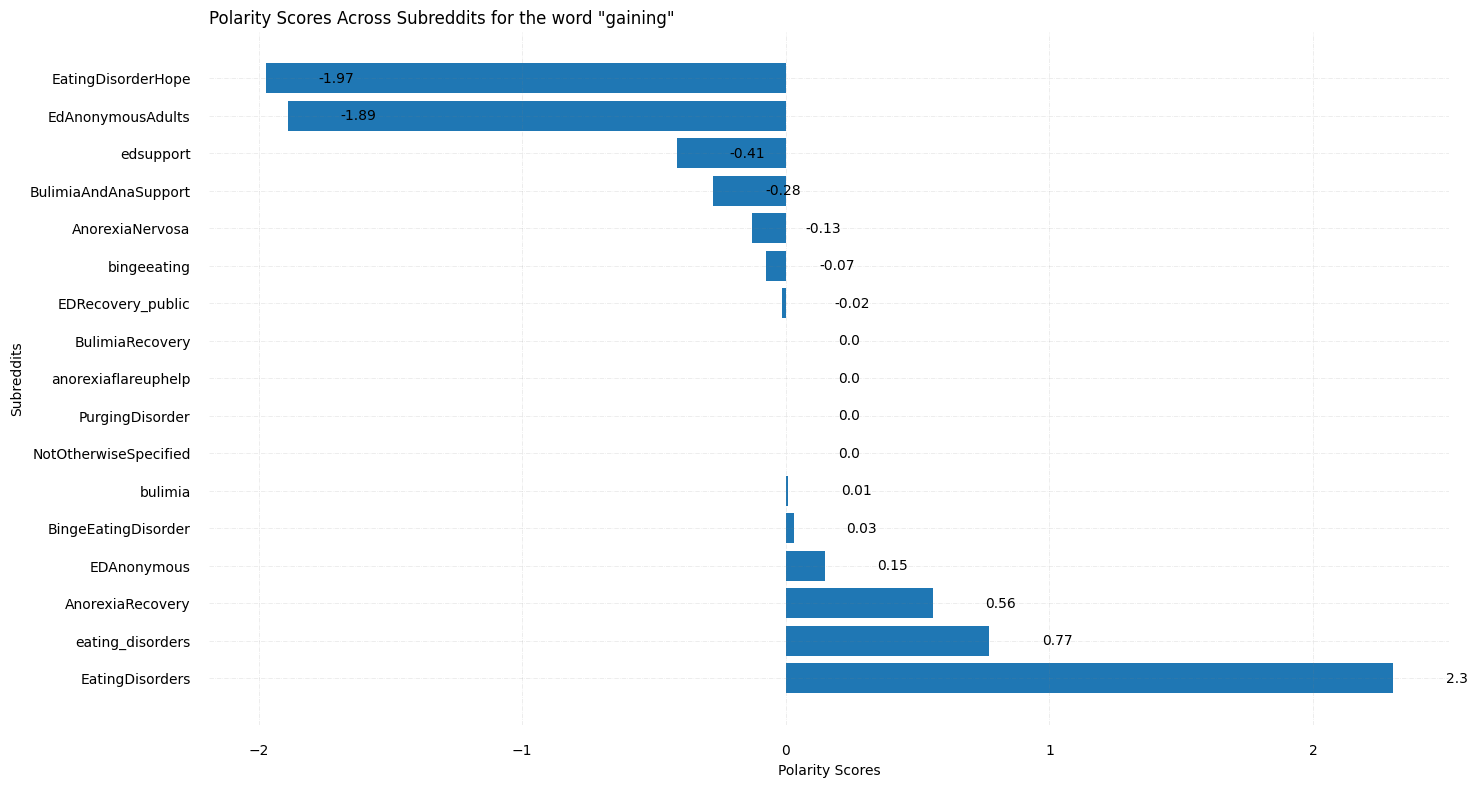

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


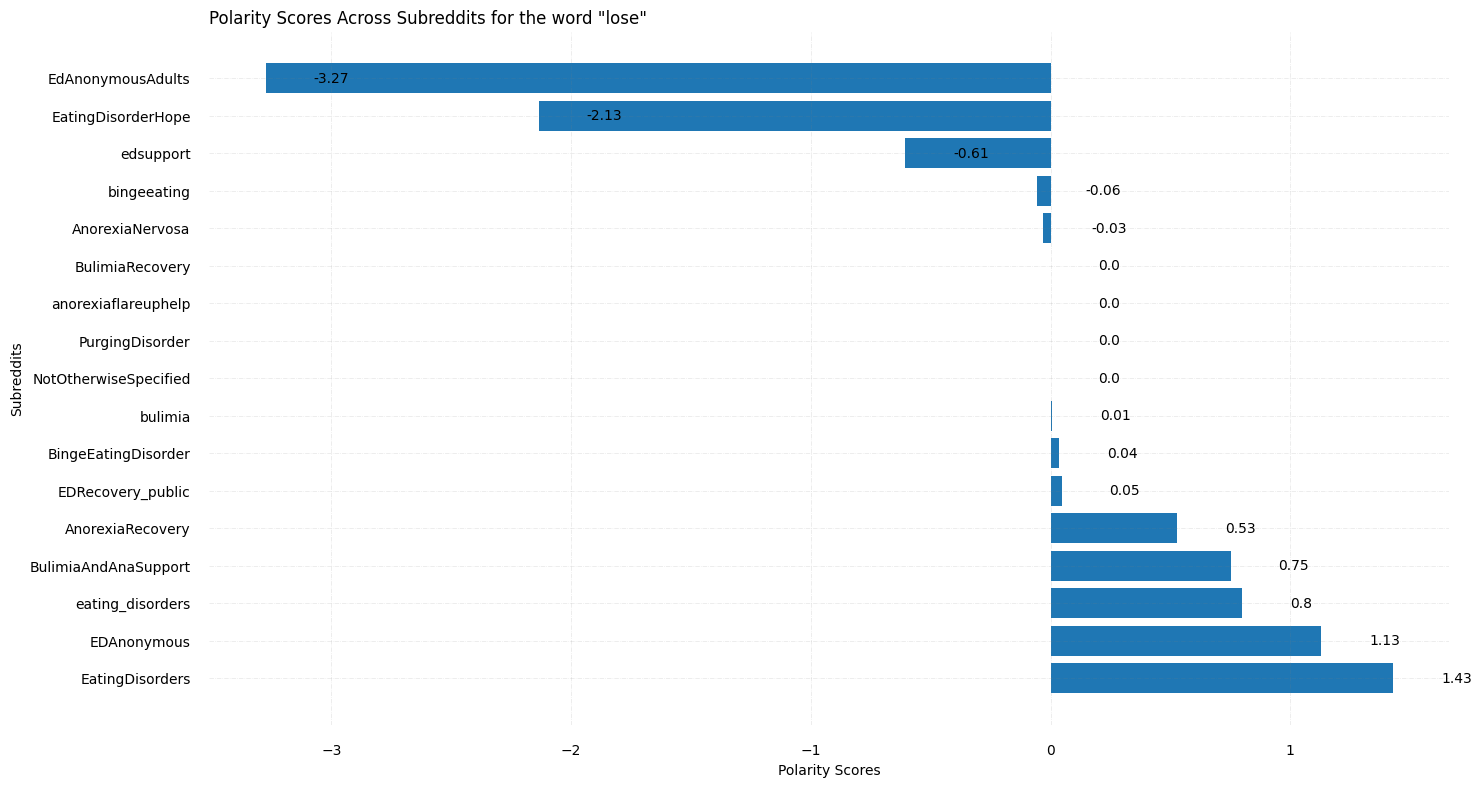

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


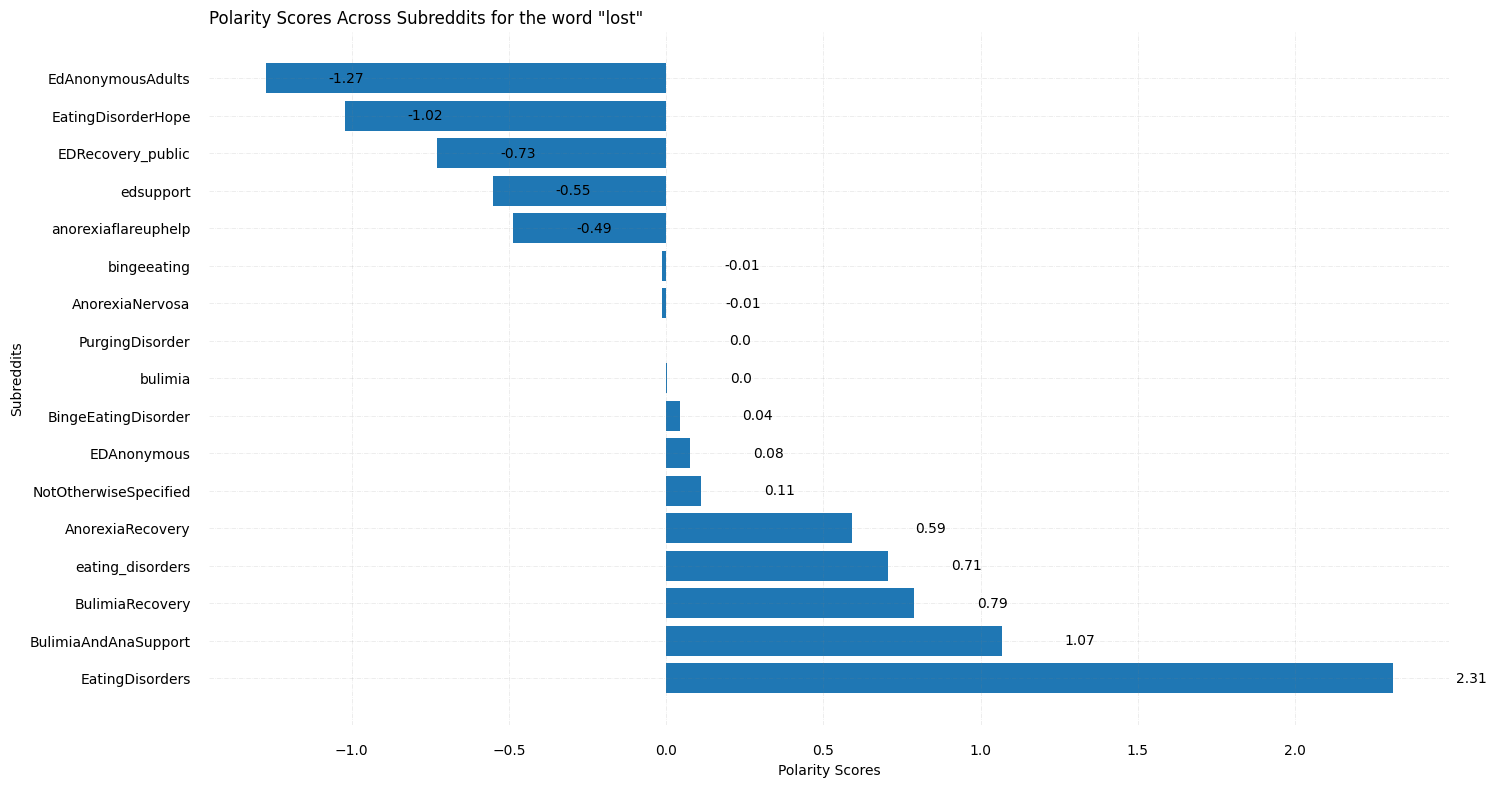

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


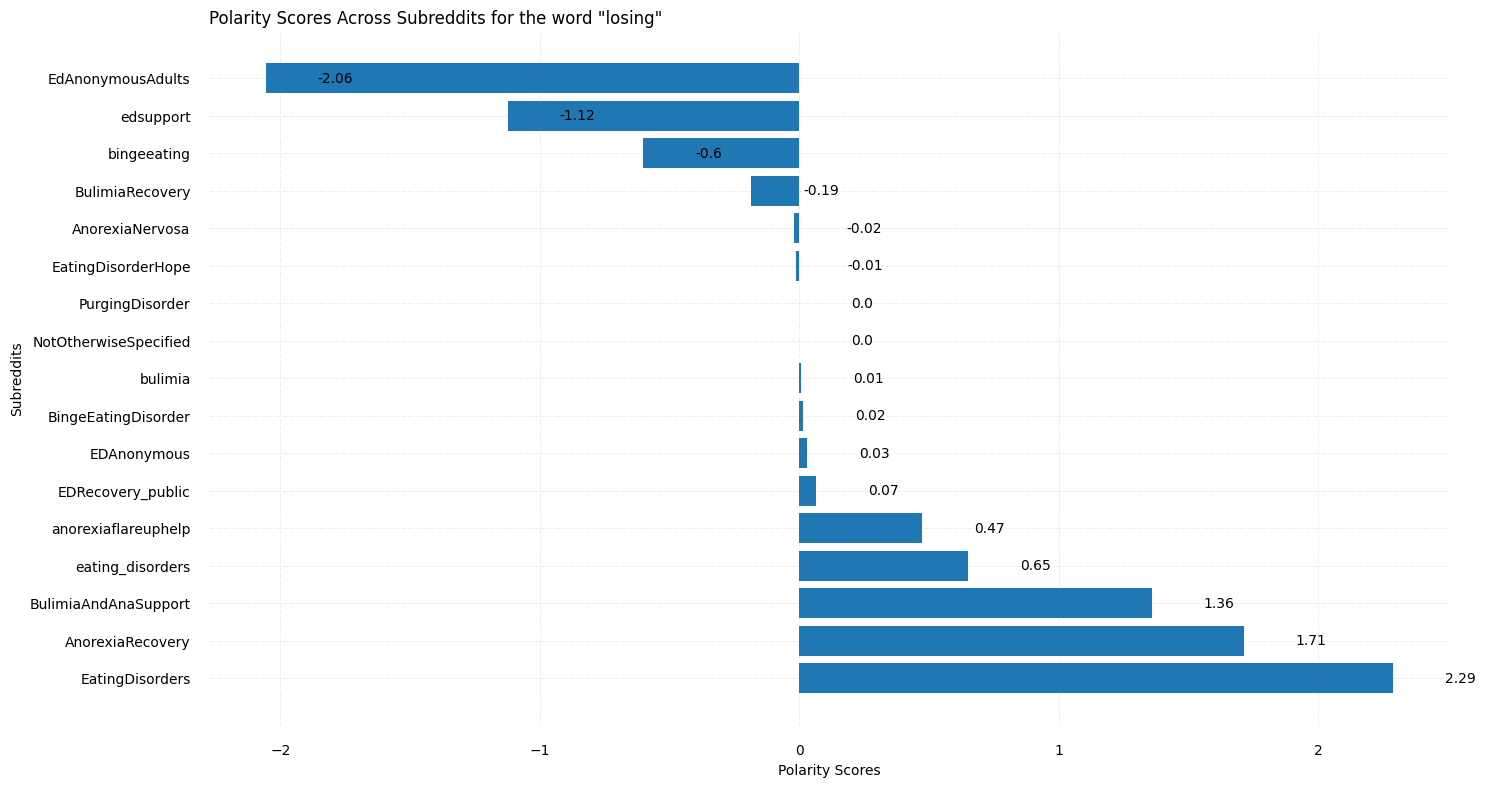

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


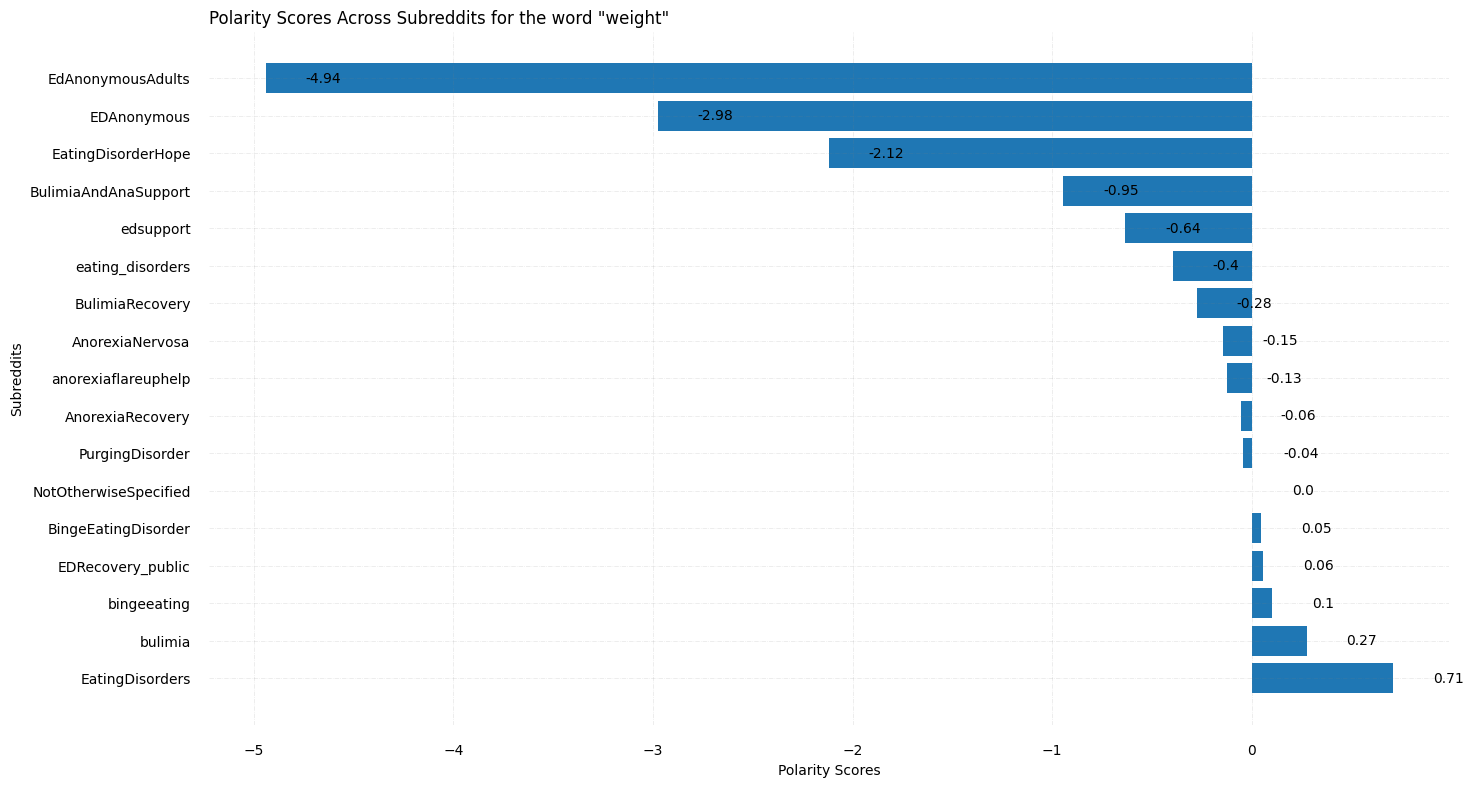

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


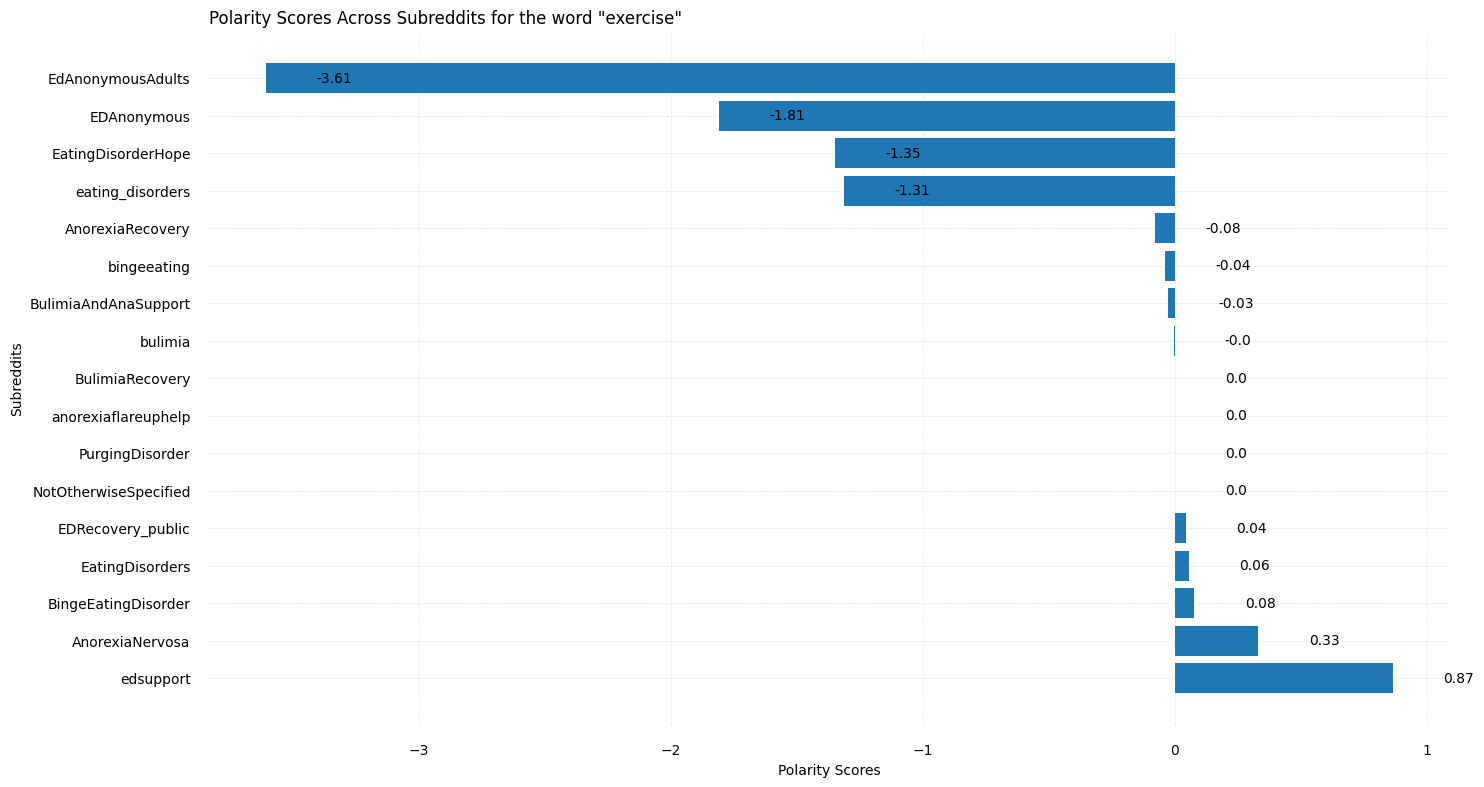

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


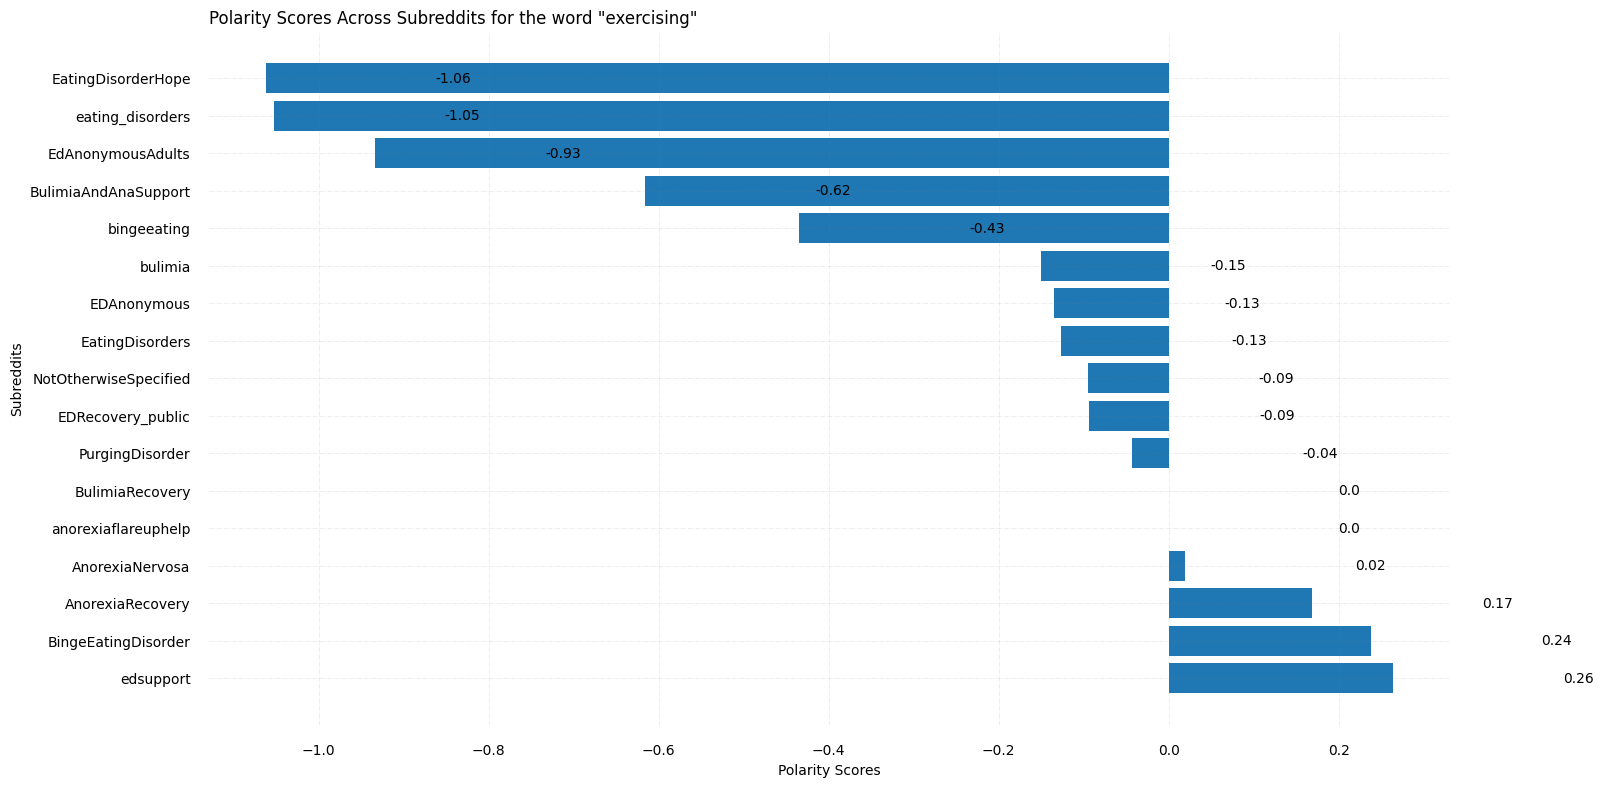

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


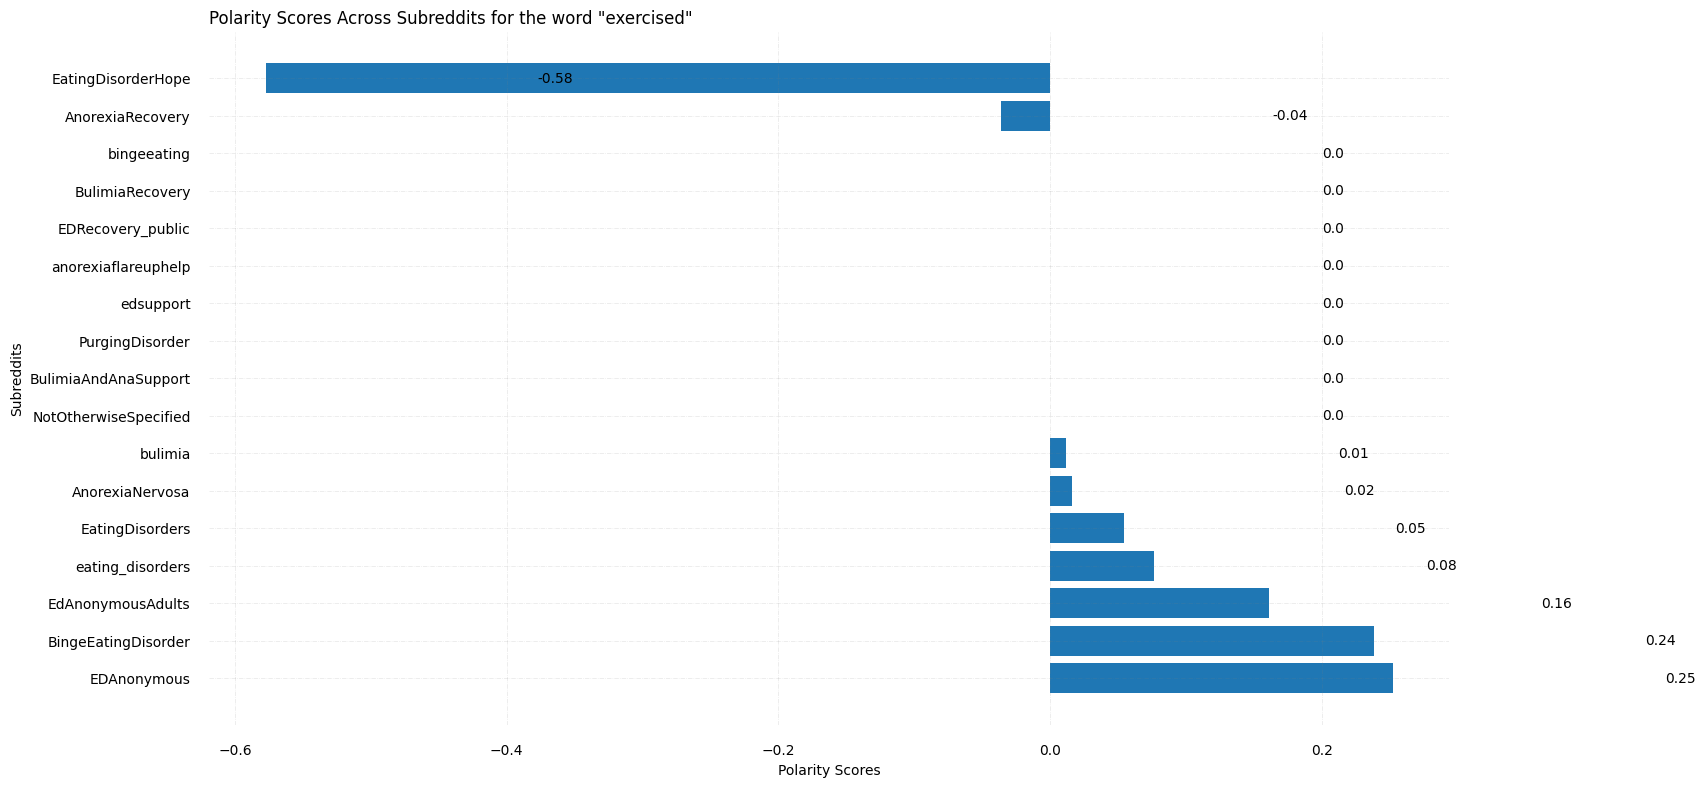

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


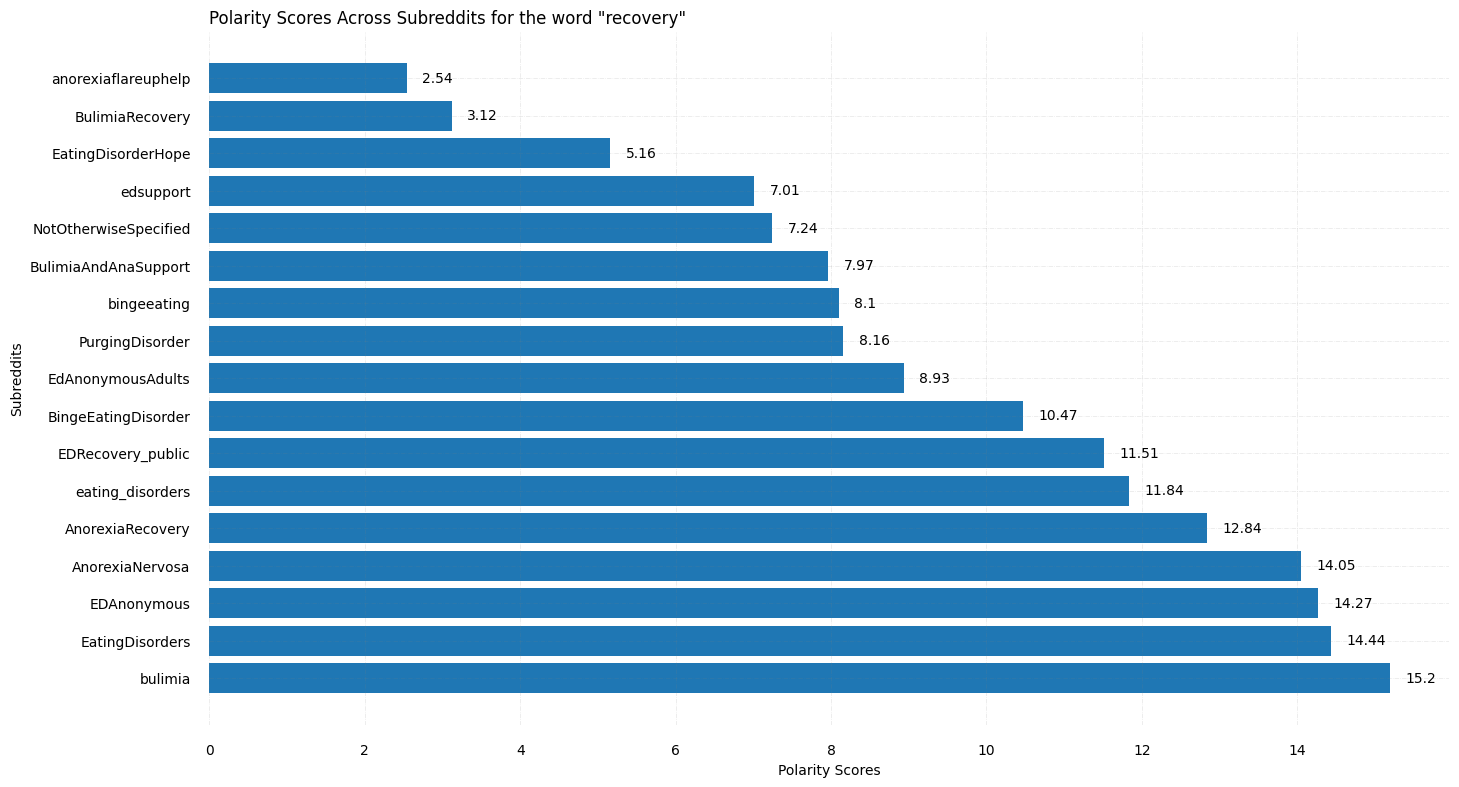

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


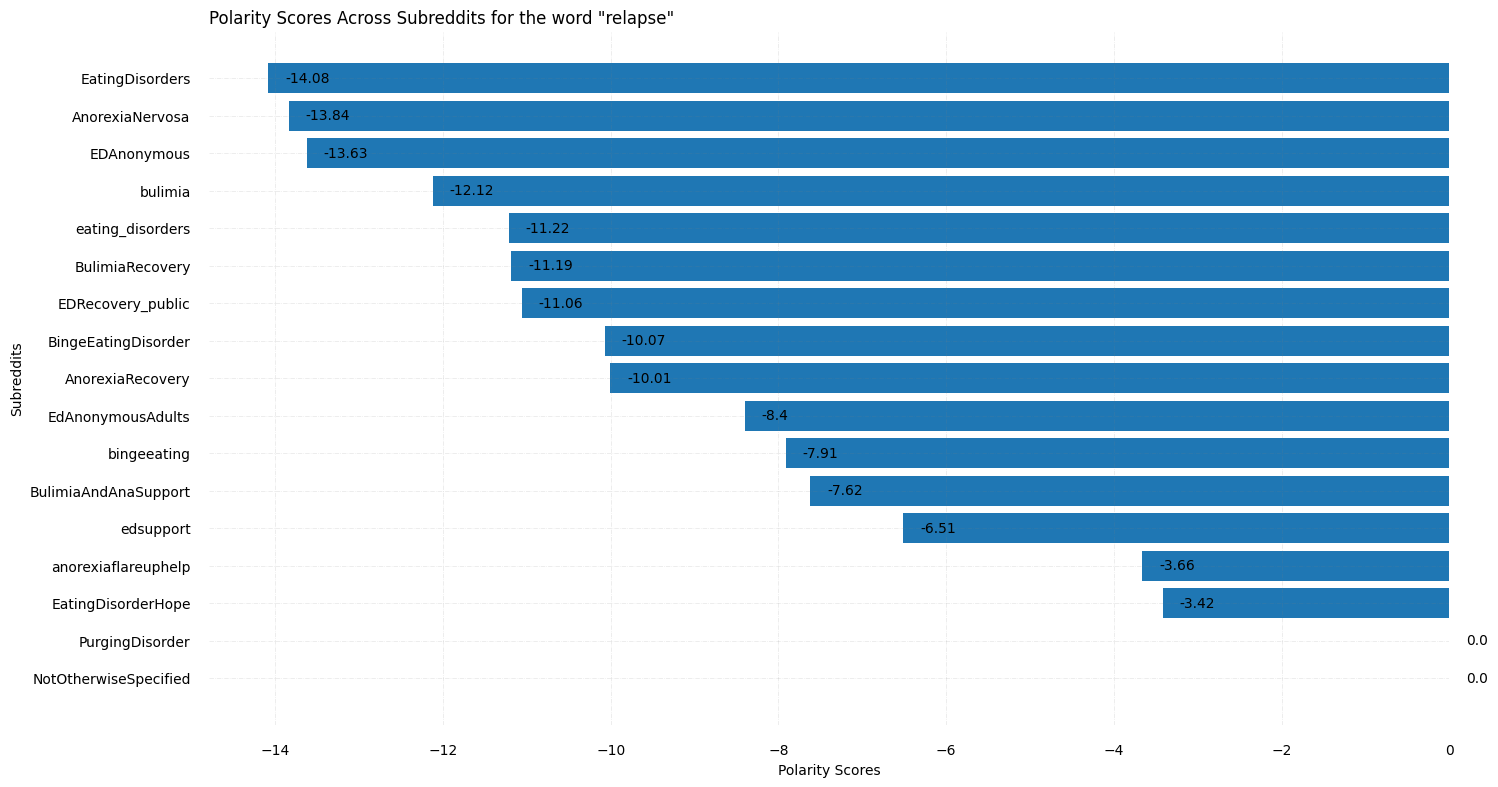

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


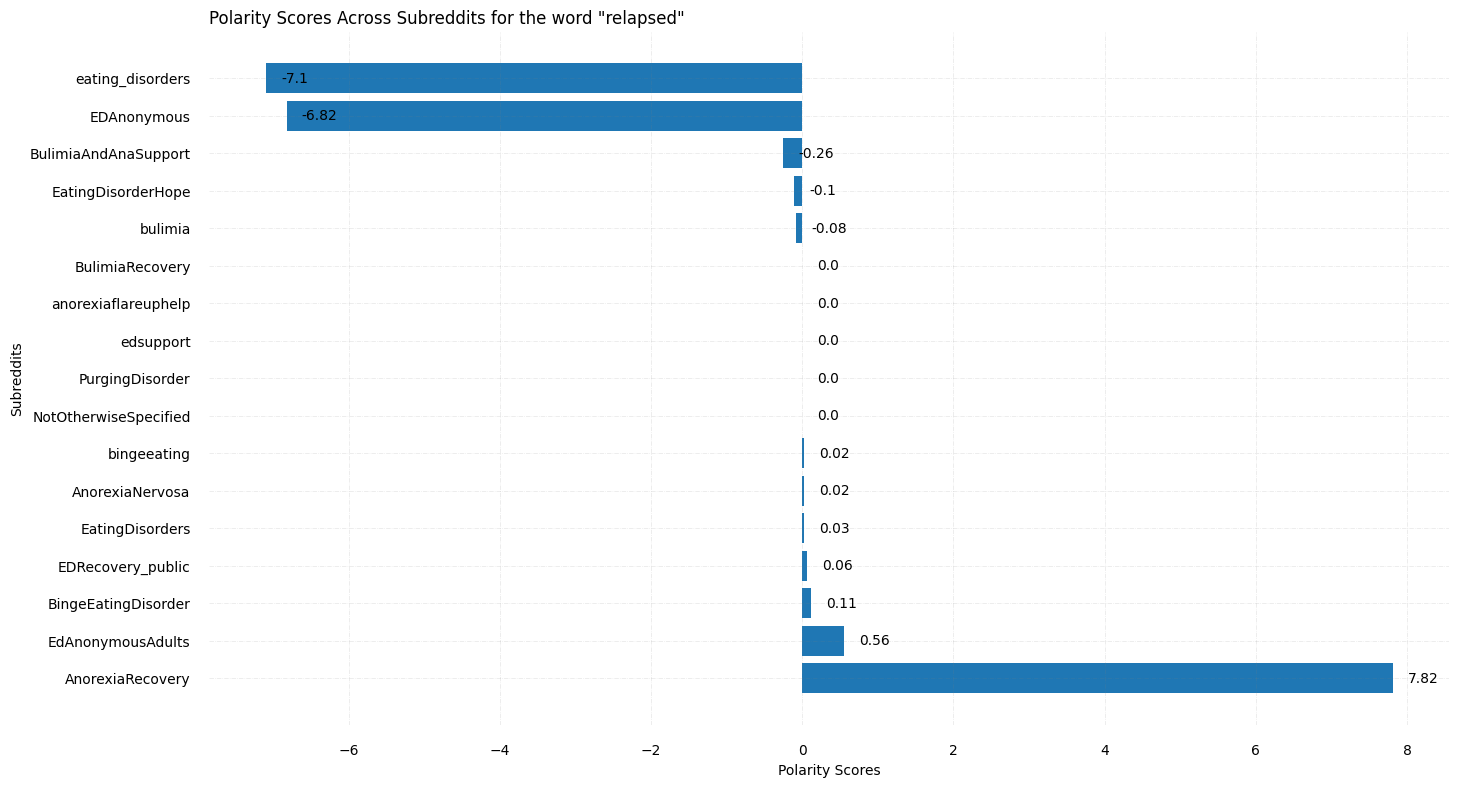

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


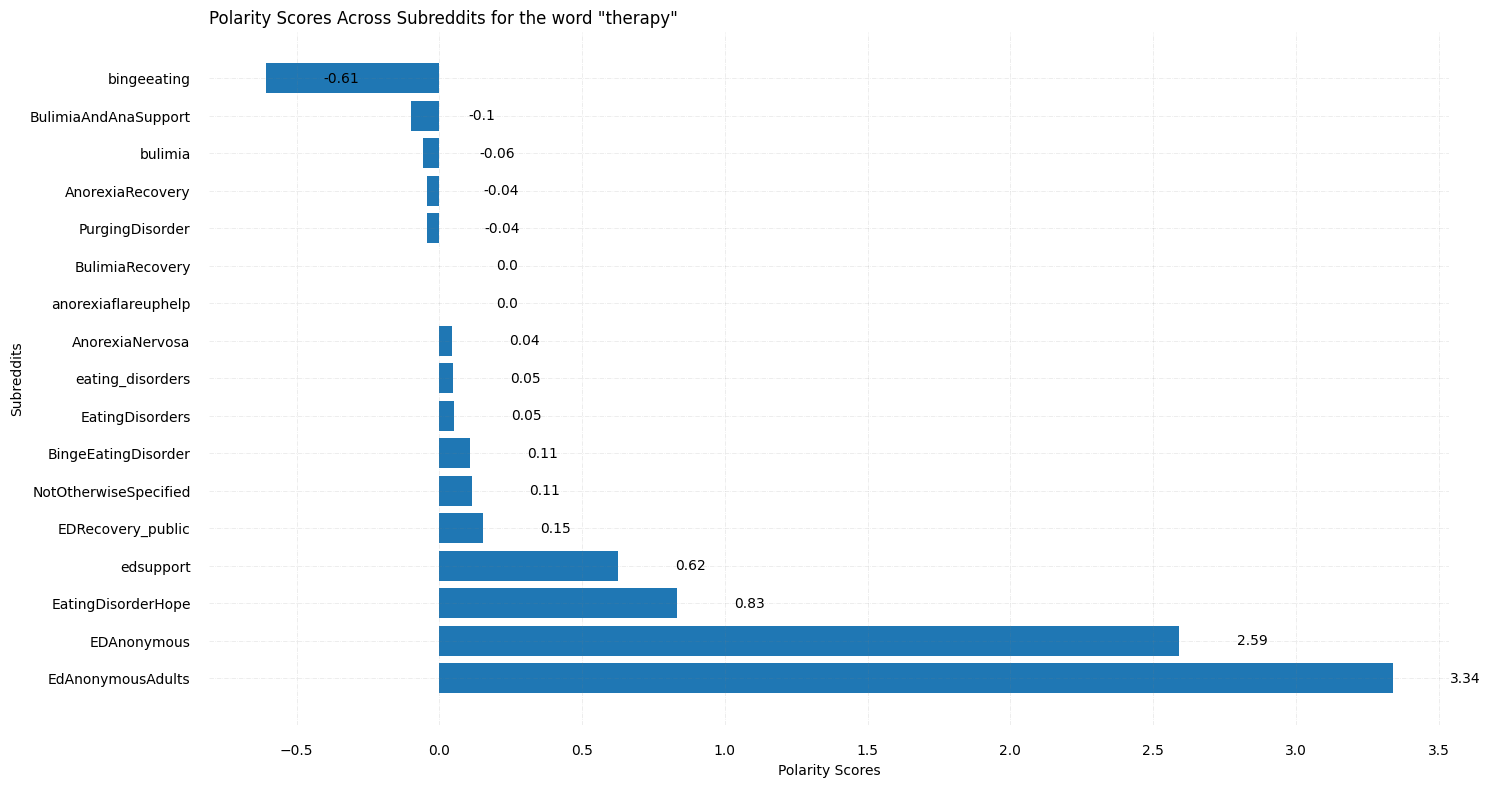

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


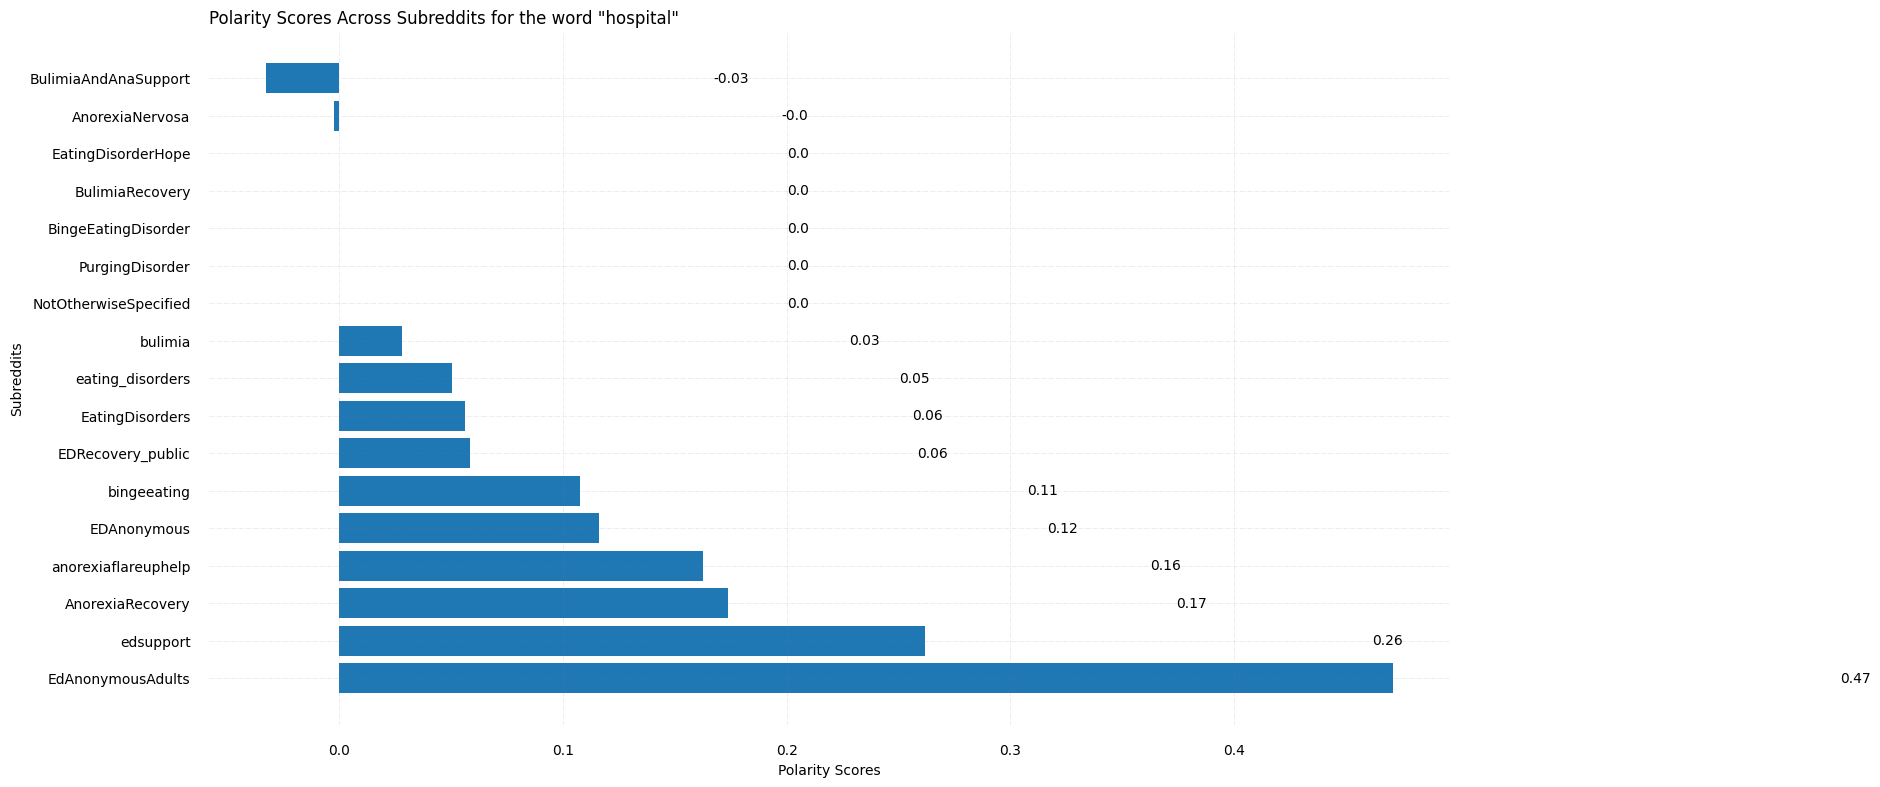

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


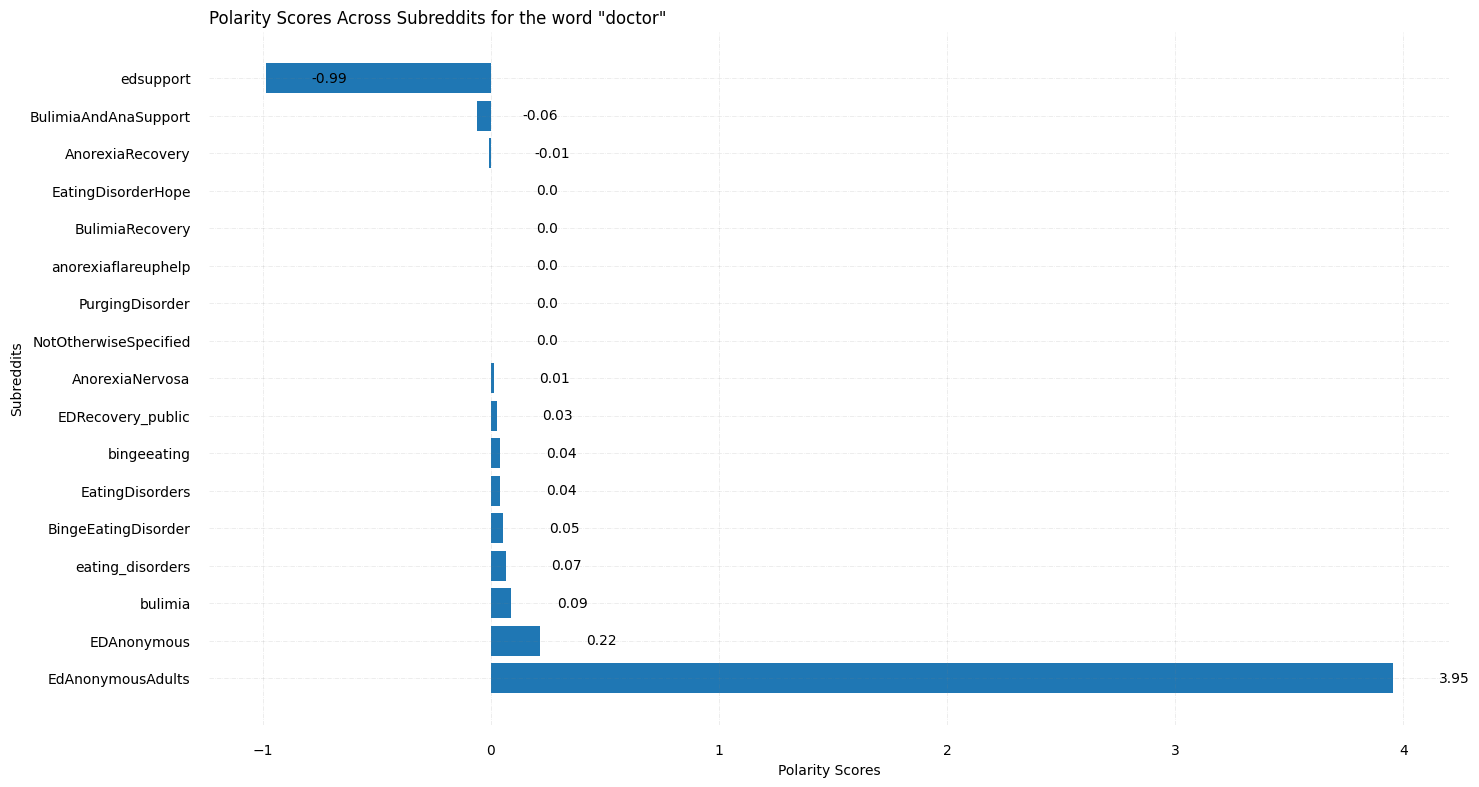

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


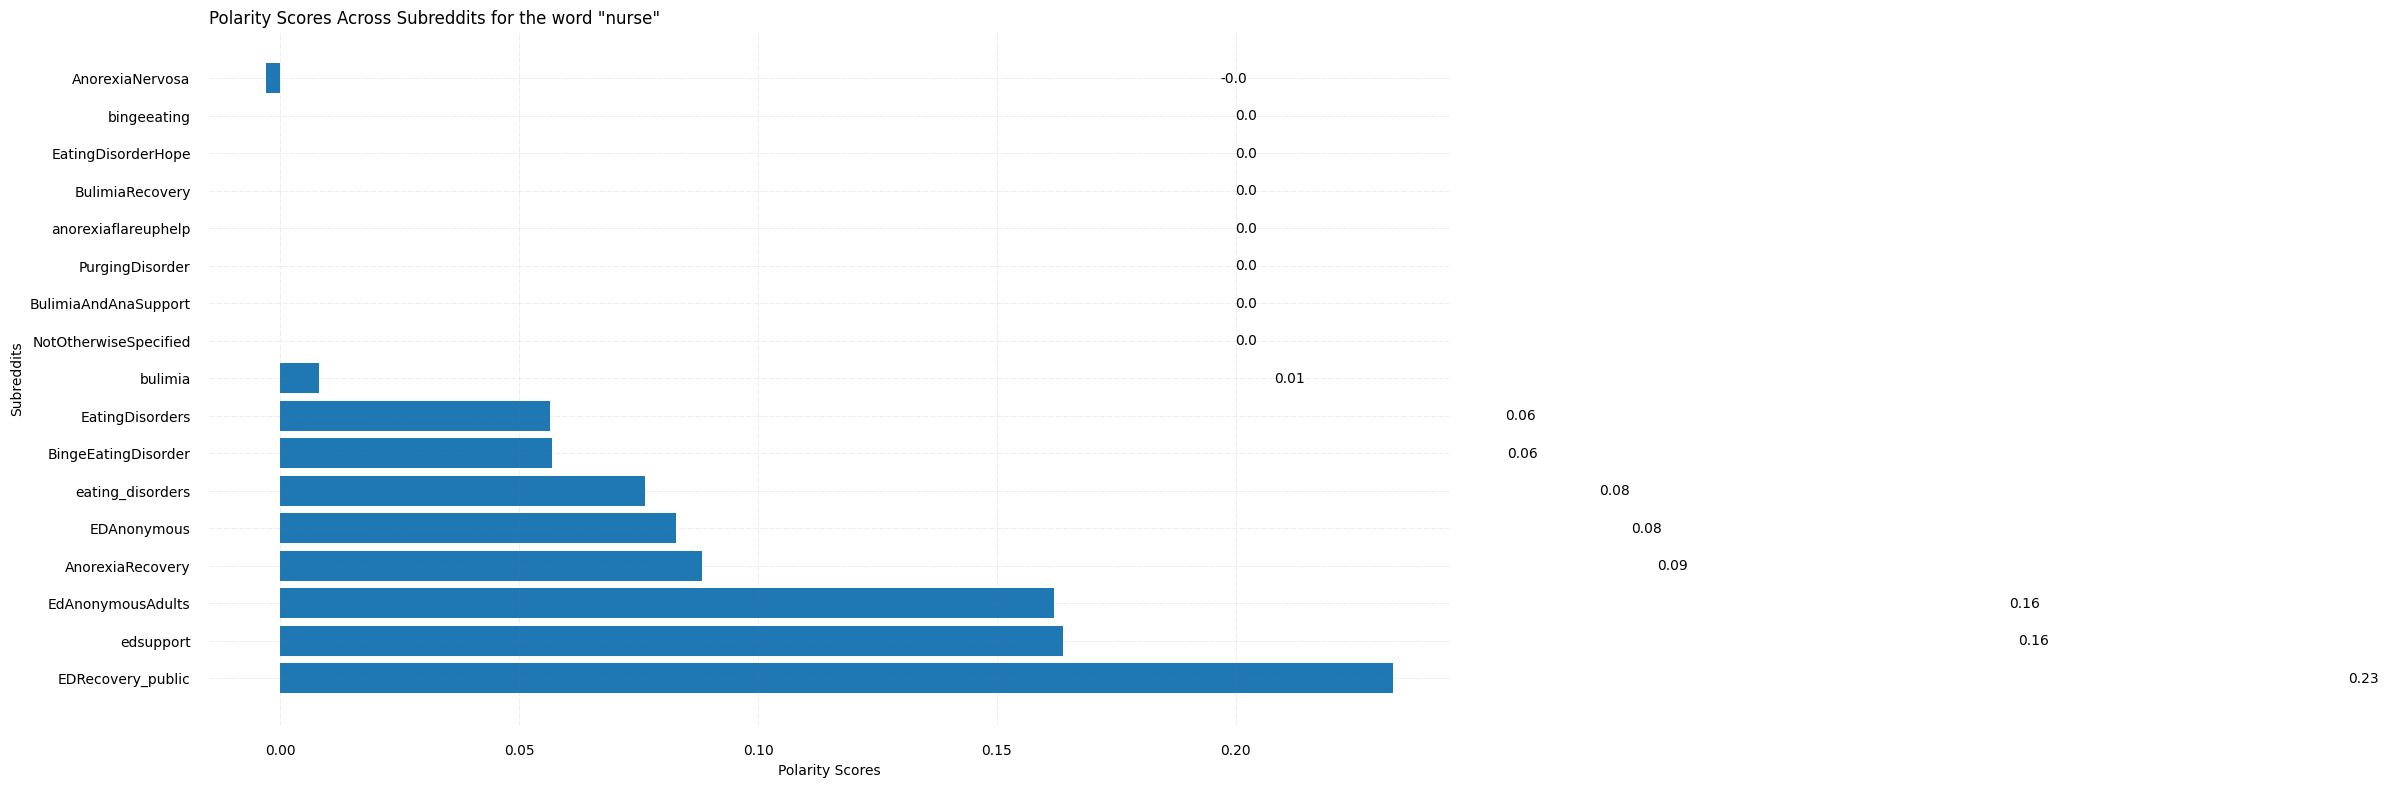

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


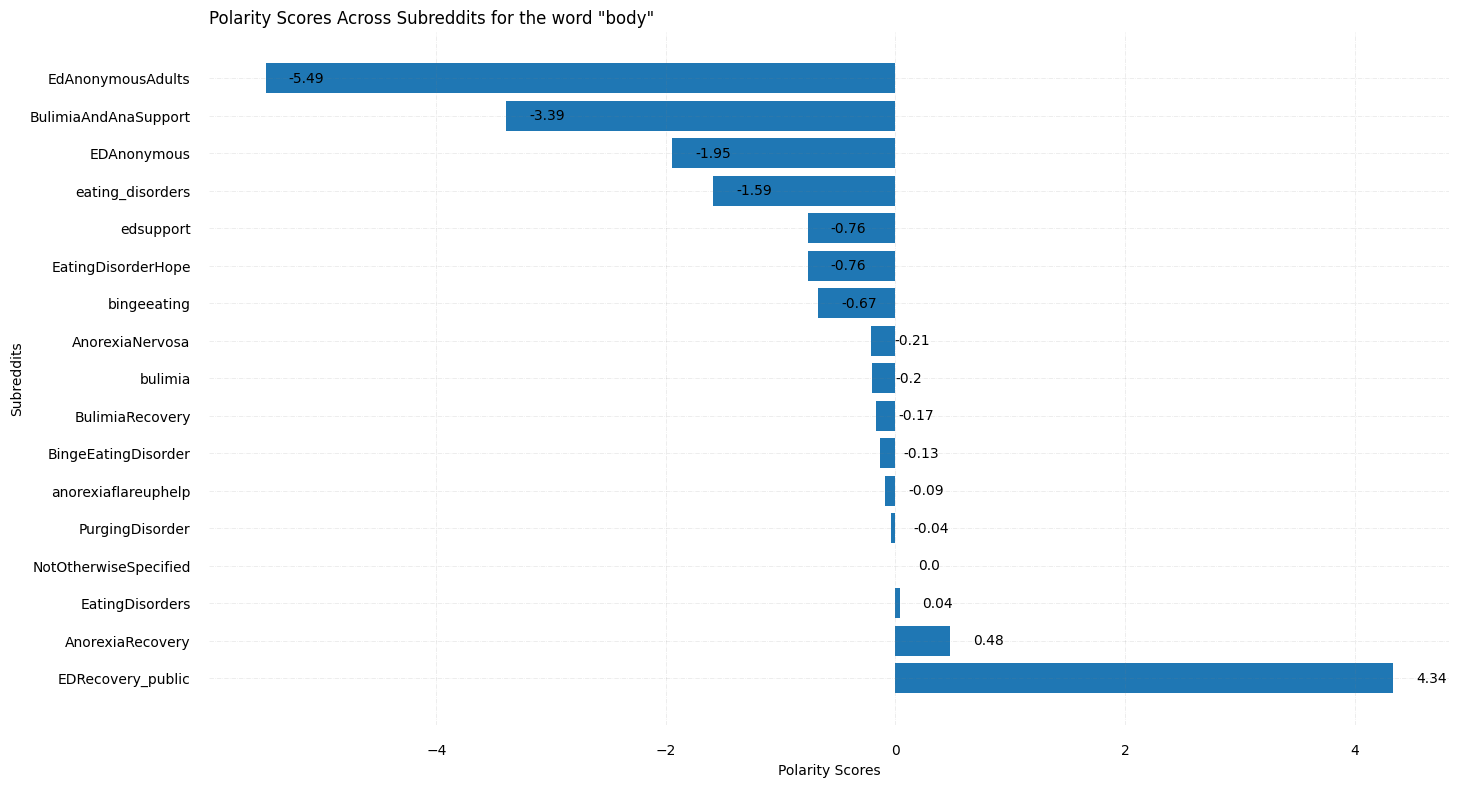

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_42051/3629329613.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


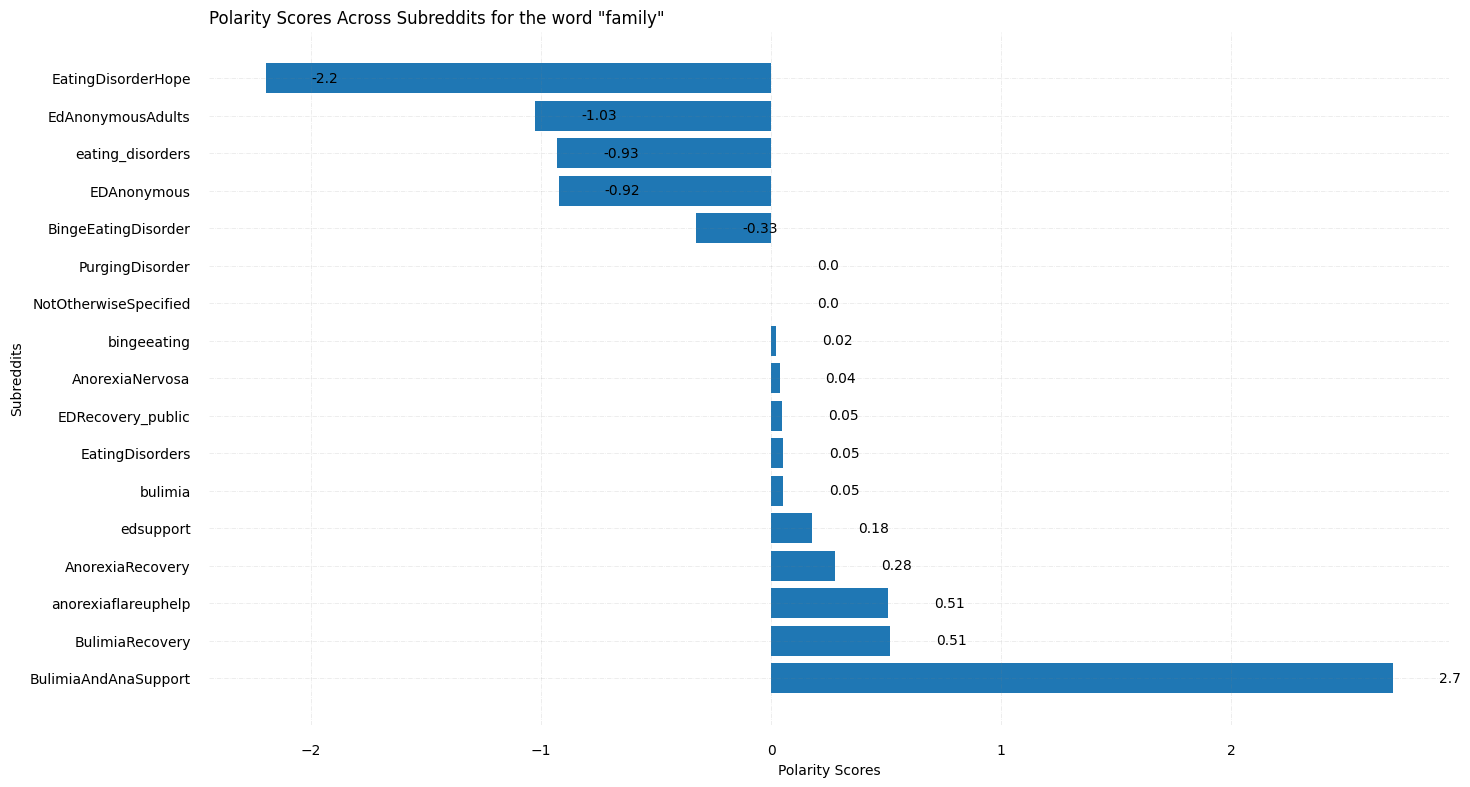

In [134]:
for keyword in keyword_scores.keys():
    subreddits = list(keyword_scores[keyword].keys())
    polarities = list(keyword_scores[keyword].values())
    # Figure Size
    fig, ax = plt.subplots(figsize =(16, 9))

    # Horizontal Bar Plot
    ax.barh(subreddits, polarities)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 10)
    ax.yaxis.set_tick_params(pad = 10)

    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)

    # Show top values
    ax.invert_yaxis()

    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5,
                 str(round((i.get_width()), 2)),
                 fontsize = 10,
                 color ='black')

    # Add Plot Title
    ax.set_title(f'Polarity Scores Across Subreddits for the word "{keyword}"',
                 loc ='left', )
    plt.ylabel("Subreddits")
    plt.xlabel("Polarity Scores")

    # Show Plot
    plt.show()
